In [1]:
import numpy as np
import torch
from alphatoe import plot, game
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload

/home/nt/miniconda3/envs/tictac/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

def numpy(t):
    return t.cpu().numpy()

In [3]:
weights = torch.load("../scripts/models/prob all 8 layer control-20230718-185339.pt")
with open("../scripts/models/prob all 8 layer control-20230718-185339.json", "r") as f:
    args= json.load(f)

In [4]:
model_cfg = HookedTransformerConfig(
        n_layers=args["n_layers"],
        n_heads=args["n_heads"],
        d_model=args["d_model"],
        d_head=args["d_head"],
        d_mlp=args["d_mlp"],
        act_fn=args["act_fn"],
        normalization_type=args["normalization_type"],
        d_vocab=11,
        d_vocab_out=10,
        n_ctx=10,
        init_weights=True,
        device=args["device"],
        seed=args["seed"])

In [5]:
model =  HookedTransformer(model_cfg)
model.load_state_dict(weights)

<All keys matched successfully>

In [6]:
def zero_output(module, input, output):
    print(output.shape)
    return torch.zeros_like(output)

In [7]:
handles = list()

In [8]:
seq_fwd = [10, 0, 1, 2, 3, 4, 5, 6, 7, 8]

handles.append(model.blocks[0].attn.register_forward_hook(zero_output))
logits_fwd = model(torch.tensor(seq_fwd))
preds_fwd = torch.softmax(logits_fwd, axis=-1)
[h.remove() for h in handles]
handles = list()

torch.Size([1, 10, 128])


In [9]:
seq_bwd = [10, 8, 7, 6, 5, 4, 3, 2, 1, 0]

handles.append(model.blocks[0].attn.register_forward_hook(zero_output))
logits_bwd = model(torch.tensor(seq_bwd))
preds_bwd = torch.softmax(logits_bwd, axis=-1)
[h.remove() for h in handles]
handles = list()

torch.Size([1, 10, 128])


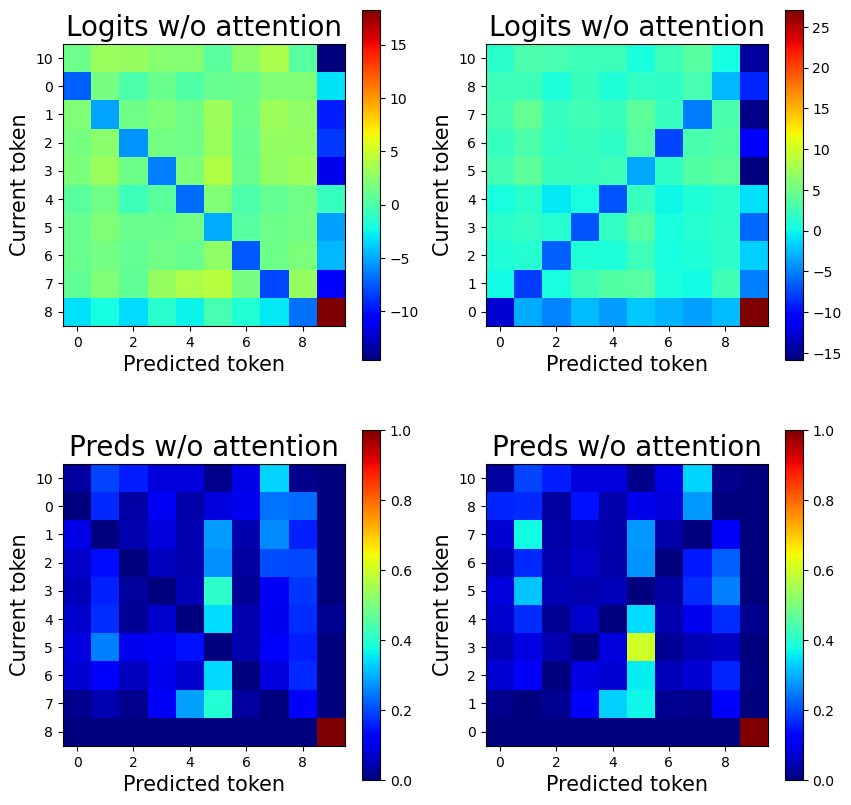

In [10]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(numpy(logits_fwd)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_fwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Logits w/o attention", fontsize=20)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(numpy(logits_bwd)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_bwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Logits w/o attention", fontsize=20)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(numpy(preds_fwd)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_fwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Preds w/o attention", fontsize=20)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(numpy(preds_bwd)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_bwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Preds w/o attention", fontsize=20)
plt.colorbar()
plt.show()

In [11]:
logits_fwd_w_att = model(torch.tensor(seq_fwd))
preds_fwd_w_att = torch.softmax(logits_fwd_w_att, axis=-1)

logits_bwd_w_att = model(torch.tensor(seq_bwd))
preds_bwd_w_att = torch.softmax(logits_bwd_w_att, axis=-1)

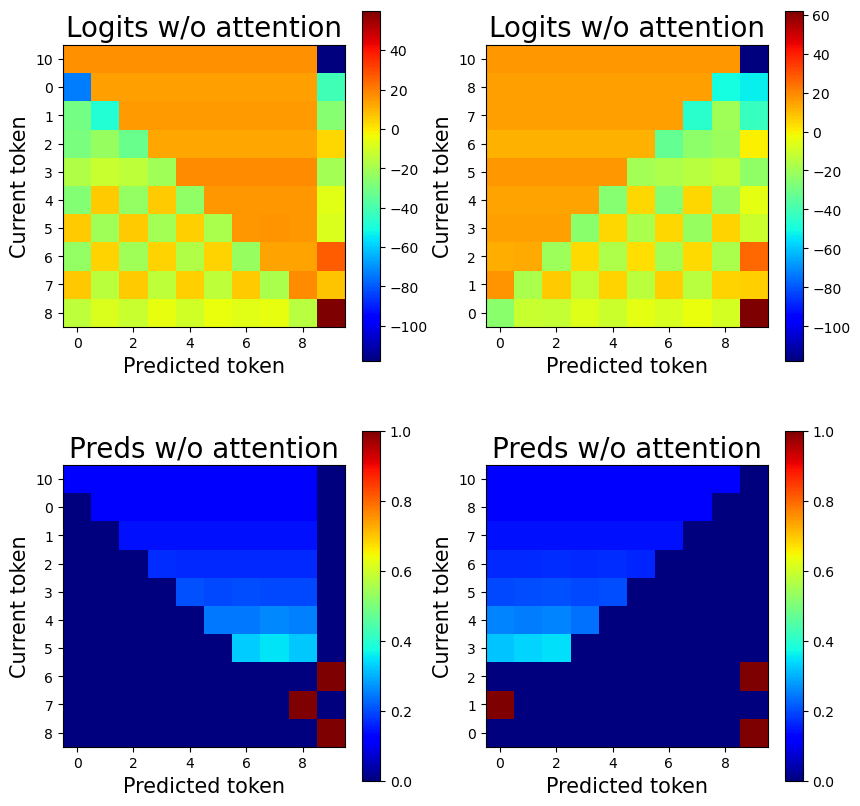

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(numpy(logits_fwd_w_att)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_fwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Logits w/o attention", fontsize=20)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(numpy(logits_bwd_w_att)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_bwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Logits w/o attention", fontsize=20)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(numpy(preds_fwd_w_att)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_fwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Preds w/o attention", fontsize=20)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(numpy(preds_bwd_w_att)[0], cmap="jet")
plt.yticks(np.arange(10), labels=seq_bwd)
plt.ylabel("Current token", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Preds w/o attention", fontsize=20)
plt.colorbar()
plt.show()

In [13]:
pos_emb = model.pos_embed(torch.zeros(1, 10), 0)
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
preds_mlp_pos = torch.softmax(logits_mlp_pos, axis=-1)

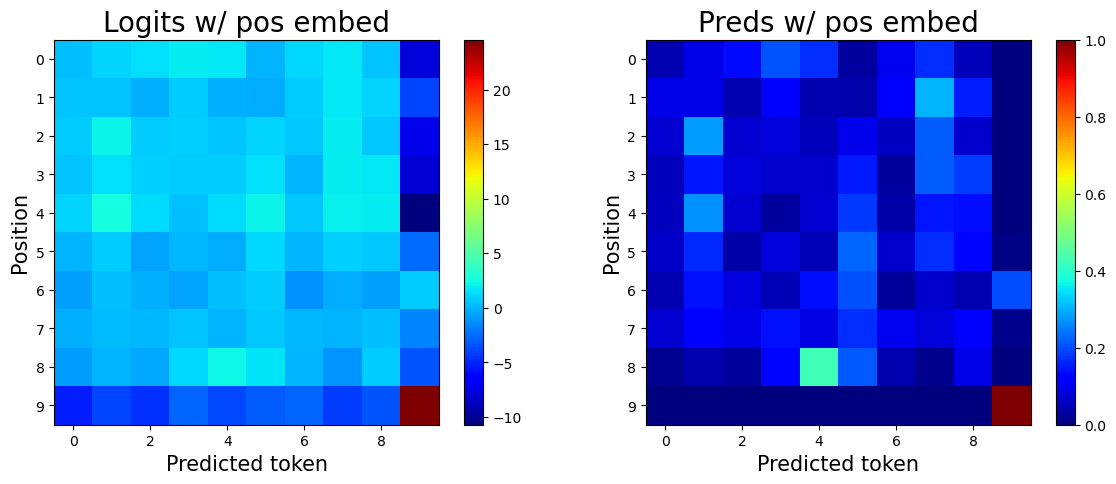

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(numpy(logits_mlp_pos)[0], cmap="jet")
plt.yticks(np.arange(10))
plt.ylabel("Position", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Logits w/ pos embed", fontsize=20)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(numpy(preds_mlp_pos)[0], cmap="jet")
plt.yticks(np.arange(10))
plt.ylabel("Position", fontsize=15)
plt.xlabel("Predicted token", fontsize=15)
plt.title("Preds w/ pos embed", fontsize=20)
plt.colorbar()
plt.show()

In [15]:
def ablate_all_but_one_head(head, seq):
    def hook(module, input, output):
        result = torch.zeros_like(output)
        result[:, :, head, :] = output[:, :, head, :]
        return result

    model.cfg.use_attn_result = True
    try:
        handle = model.blocks[0].attn.hook_result.register_forward_hook(hook)
        logits = model(torch.tensor(seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits

In [16]:
def plot_ablate_all_but_one_head(head, seq):
    plt.figure(figsize=(14, 5))

    logits = ablate_all_but_one_head(head, seq)
    preds = torch.softmax(logits, axis=-1)

    plt.subplot(1, 2, 1)
    plt.yticks(np.arange(10), labels=seq)
    plt.imshow(numpy(logits)[0], cmap="jet")
    plt.yticks(np.arange(10))
    plt.ylabel("Position", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Logits w/ pos embed", fontsize=20)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.yticks(np.arange(10), labels=seq)
    plt.imshow(numpy(preds)[0], cmap="jet")
    plt.yticks(np.arange(10))
    plt.ylabel("Position", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Preds w/ pos embed", fontsize=20)
    plt.colorbar()

    plt.suptitle(str(head), fontsize=20)

    plt.show()

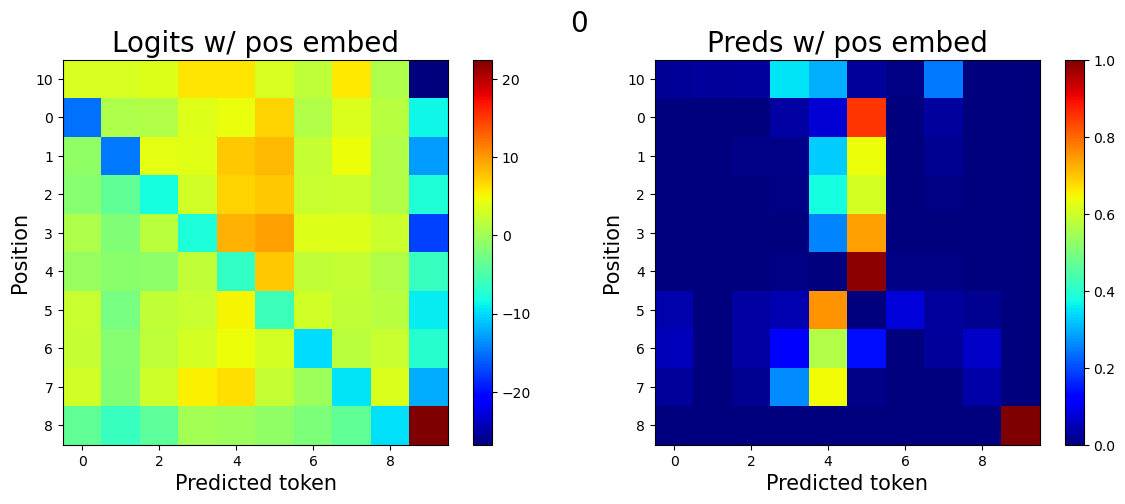

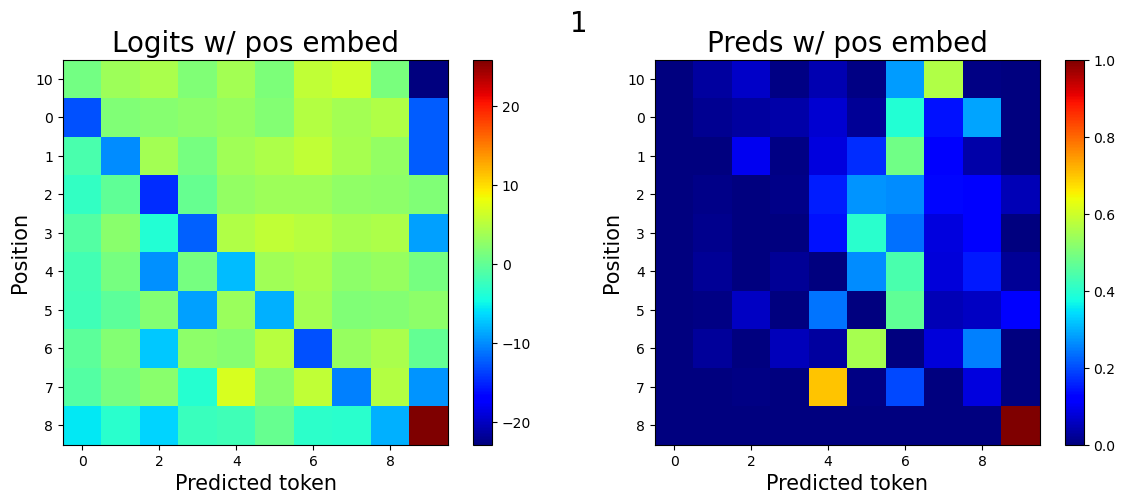

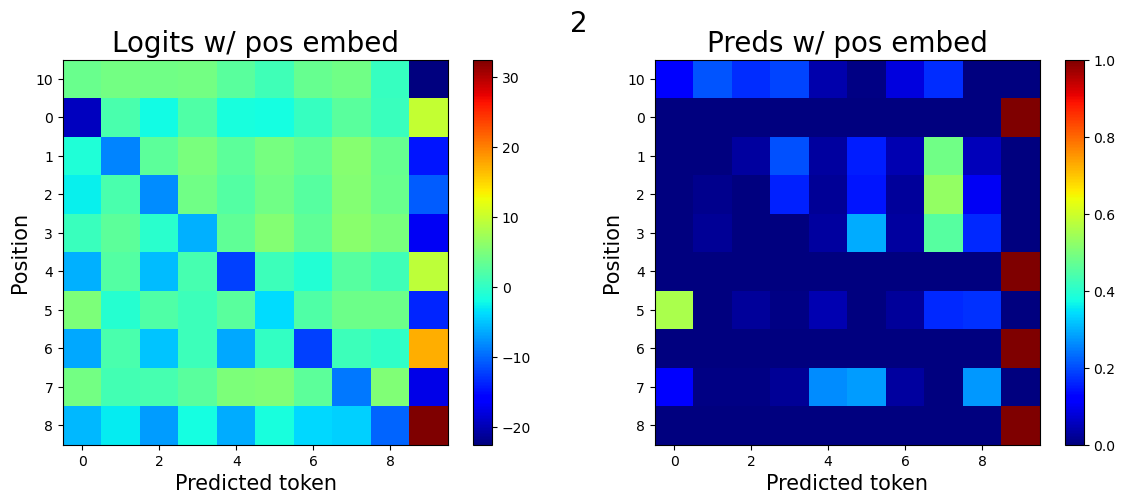

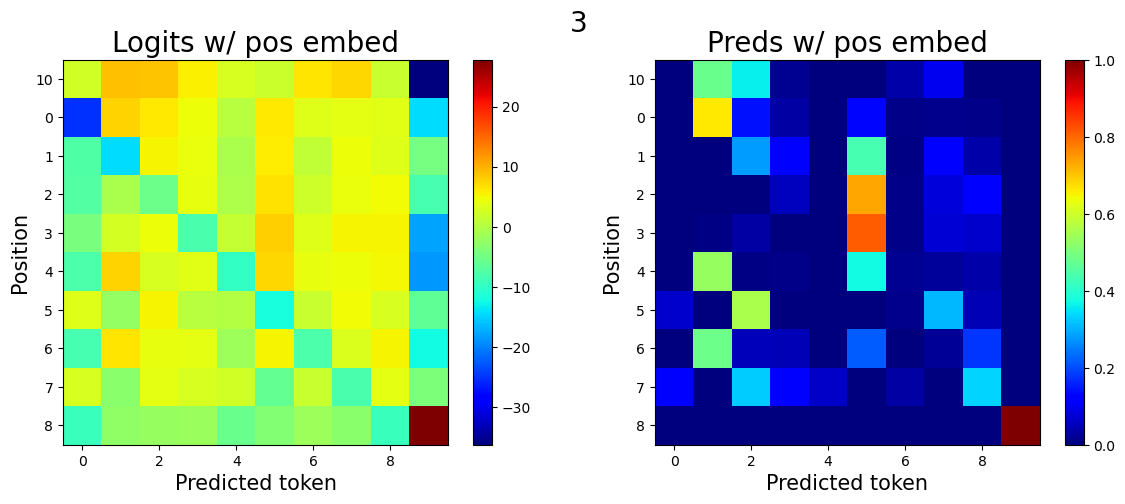

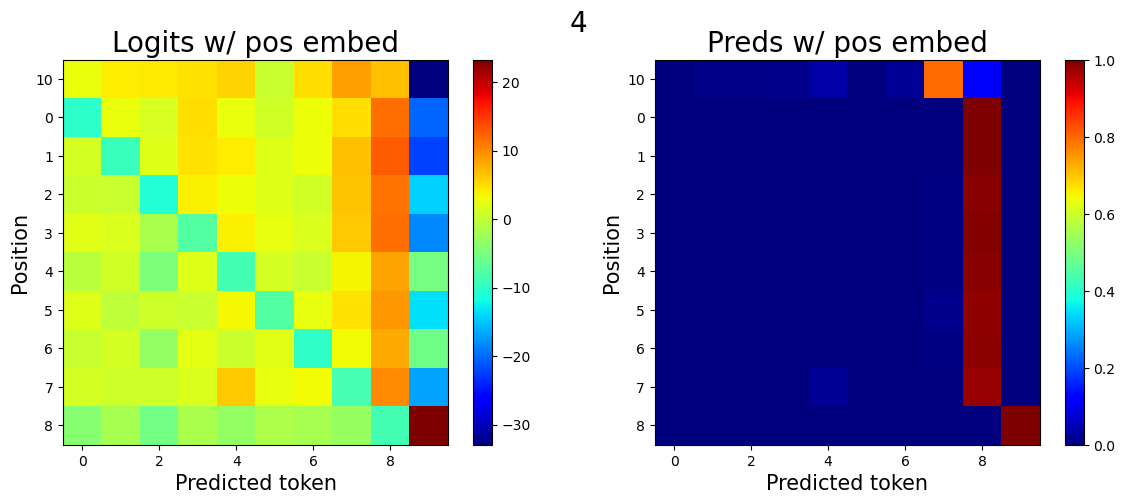

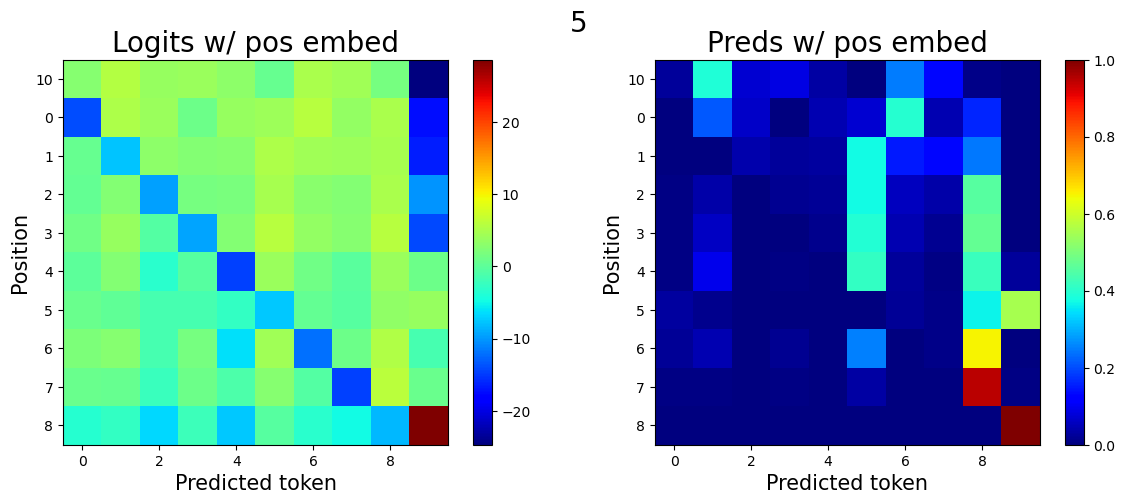

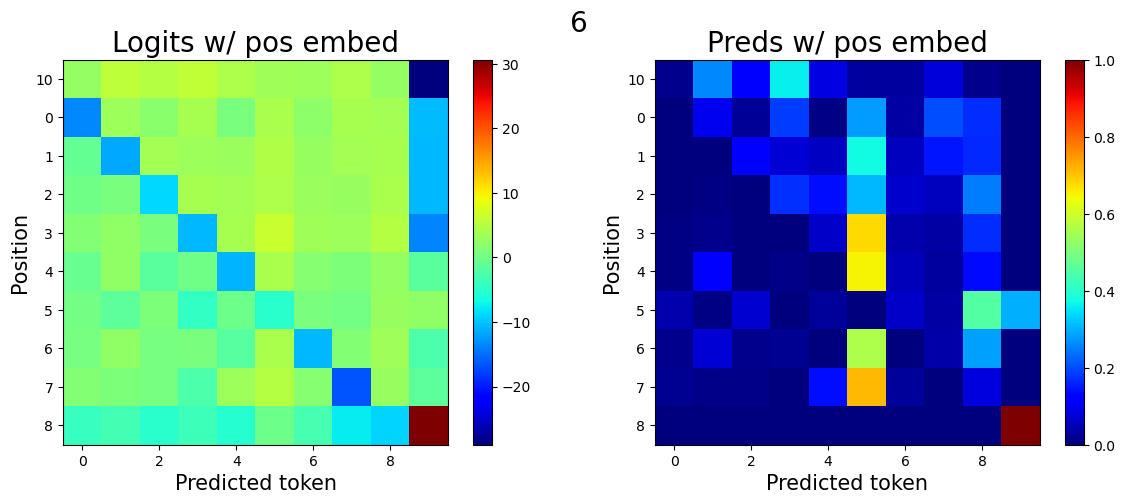

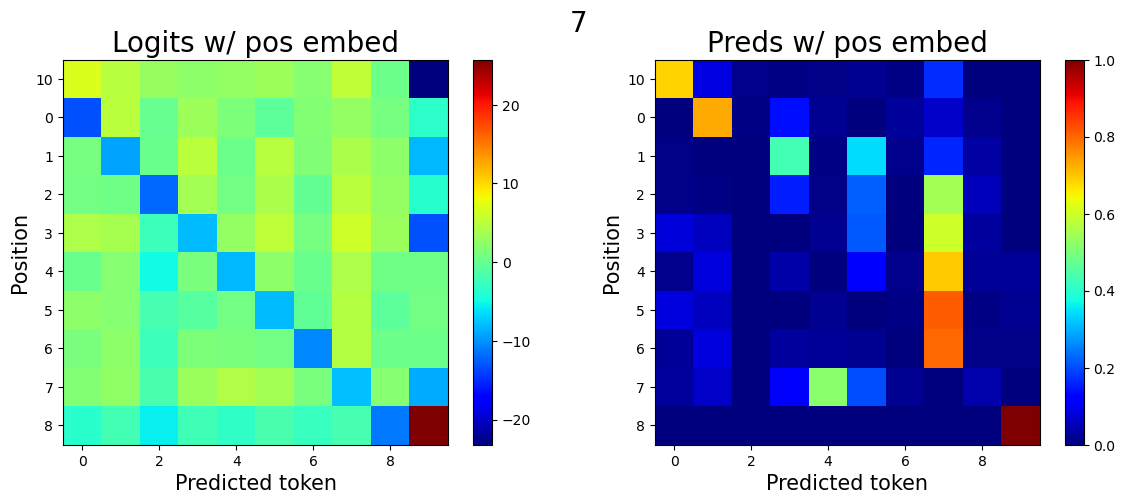

In [17]:
for i in range(8):
    plot_ablate_all_but_one_head(i, seq_fwd)

In [18]:
def ablate_one_head(head, seq):
    def hook(module, input, output):
        result = output.clone()
        result[:, :, head, :] = 0
        return result

    model.cfg.use_attn_result = True
    try:
        handle = model.blocks[0].attn.hook_result.register_forward_hook(hook)
        logits = model(torch.tensor(seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits

In [19]:
def plot_ablate_one_head(head, seq):
    plt.figure(figsize=(14, 5))

    logits = ablate_one_head(head, seq)
    preds = torch.softmax(logits, axis=-1)

    plt.subplot(1, 2, 1)
    plt.yticks(np.arange(10), labels=seq)
    plt.imshow(numpy(logits)[0], cmap="jet")
    plt.yticks(np.arange(10))
    plt.ylabel("Position", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Logits w/ pos embed", fontsize=20)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.yticks(np.arange(10), labels=seq)
    plt.imshow(numpy(preds)[0], cmap="jet")
    plt.yticks(np.arange(10))
    plt.ylabel("Position", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Preds w/ pos embed", fontsize=20)
    plt.colorbar()

    plt.suptitle(str(head), fontsize=20)

    plt.show()

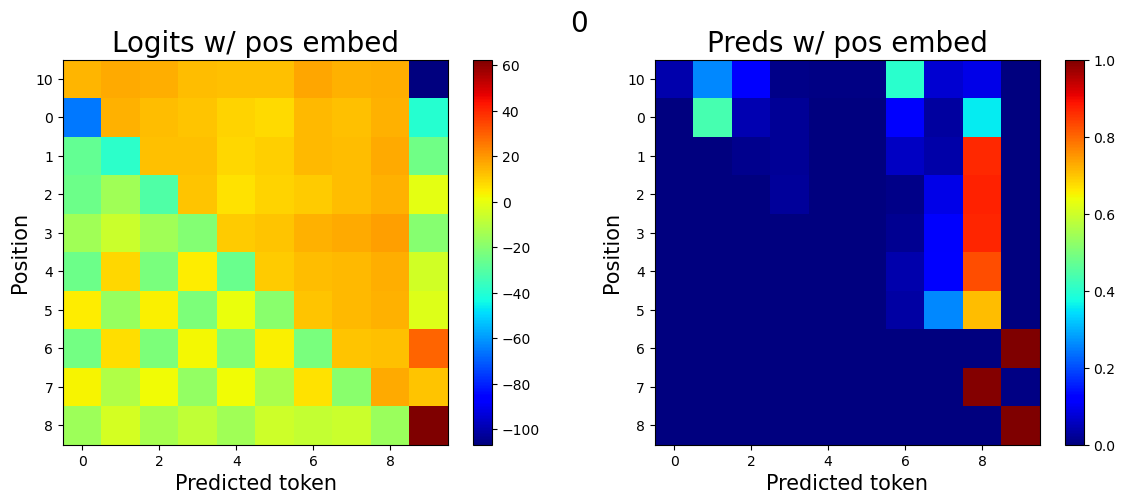

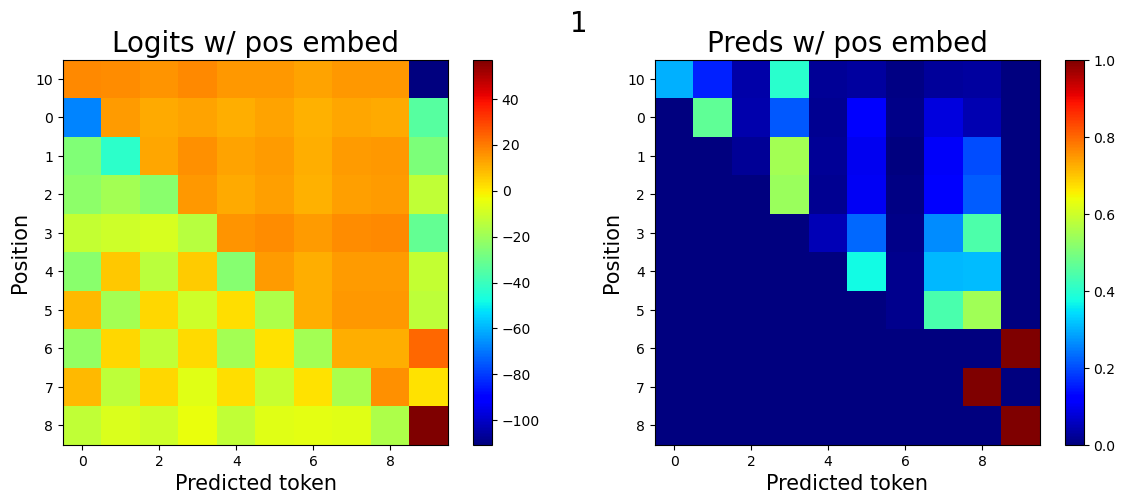

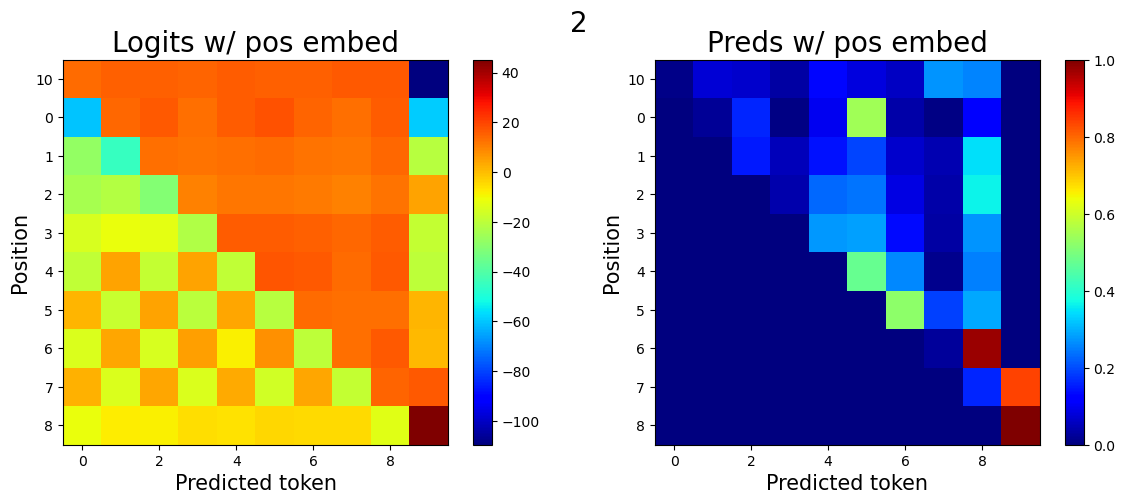

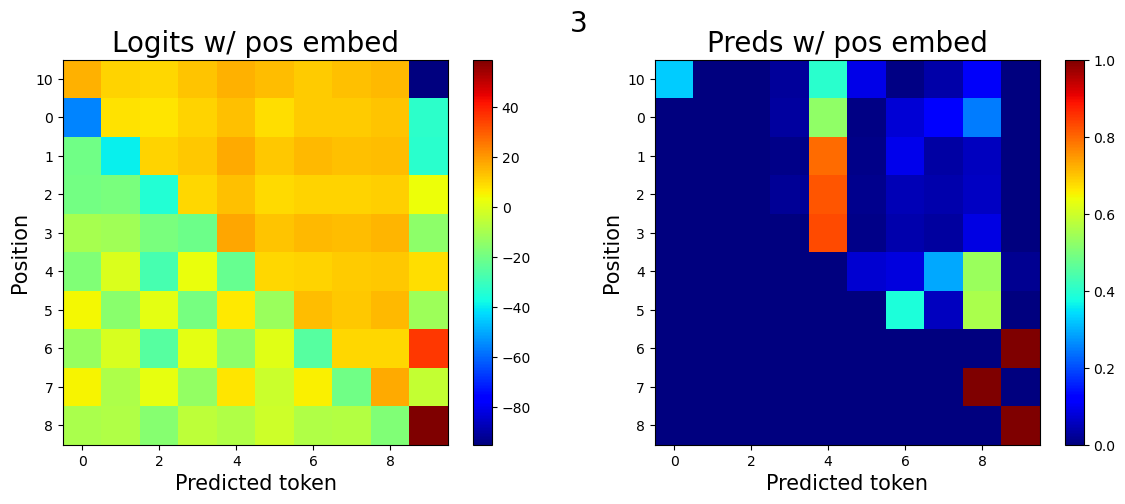

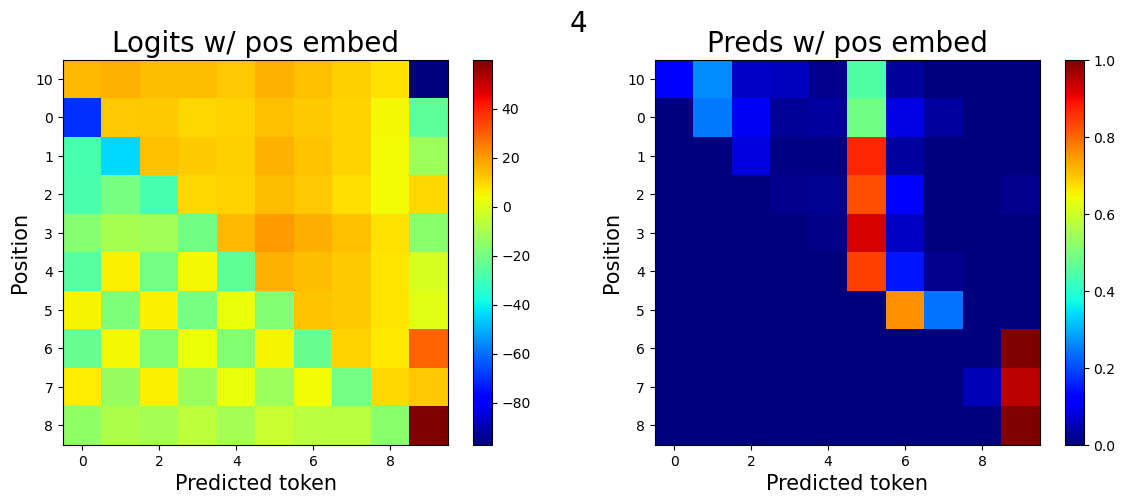

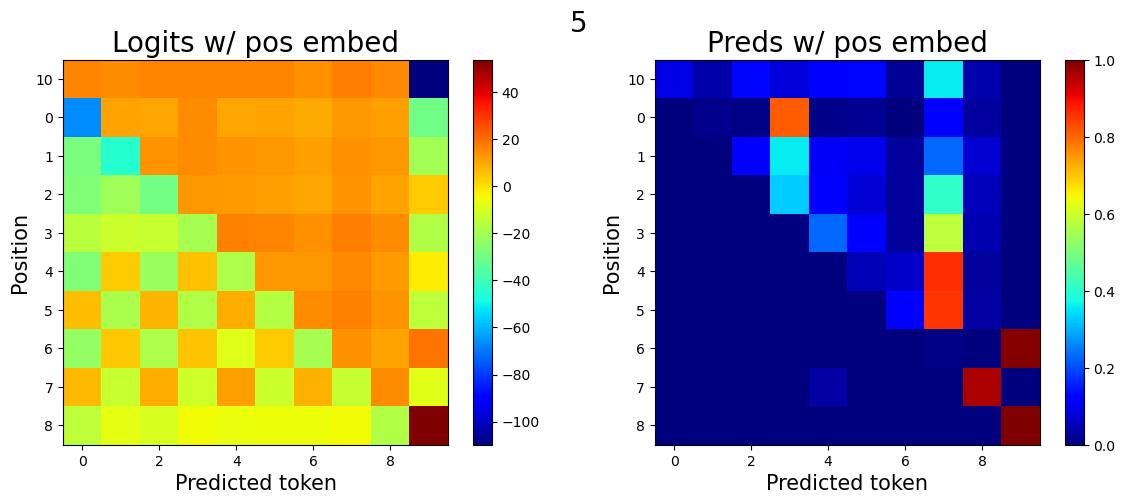

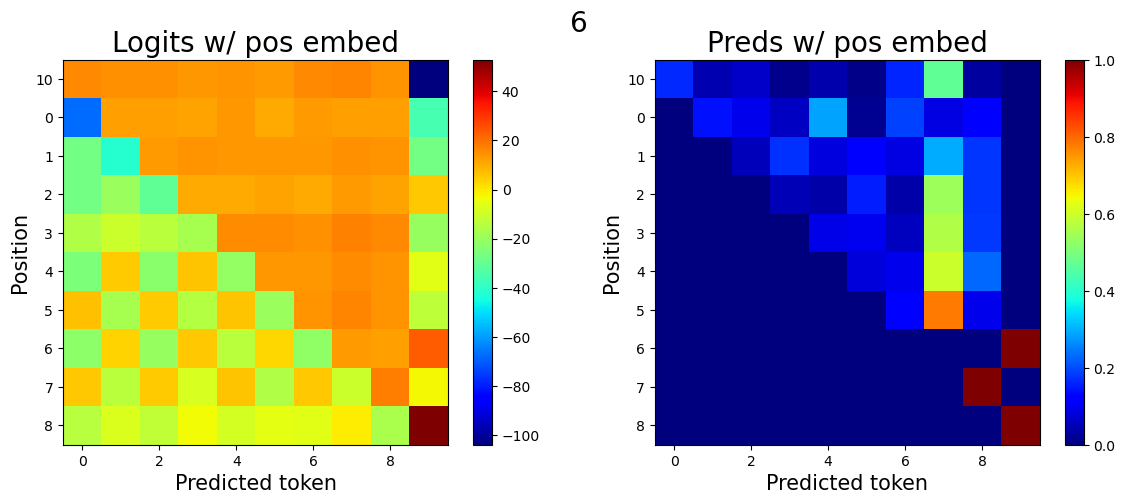

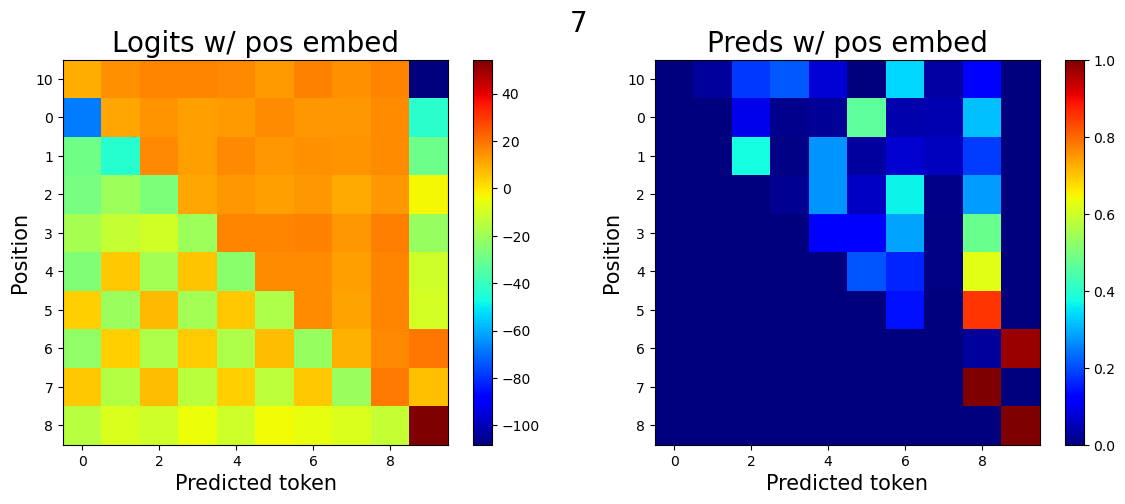

In [20]:
for i in range(8):
    plot_ablate_one_head(i, seq_fwd)

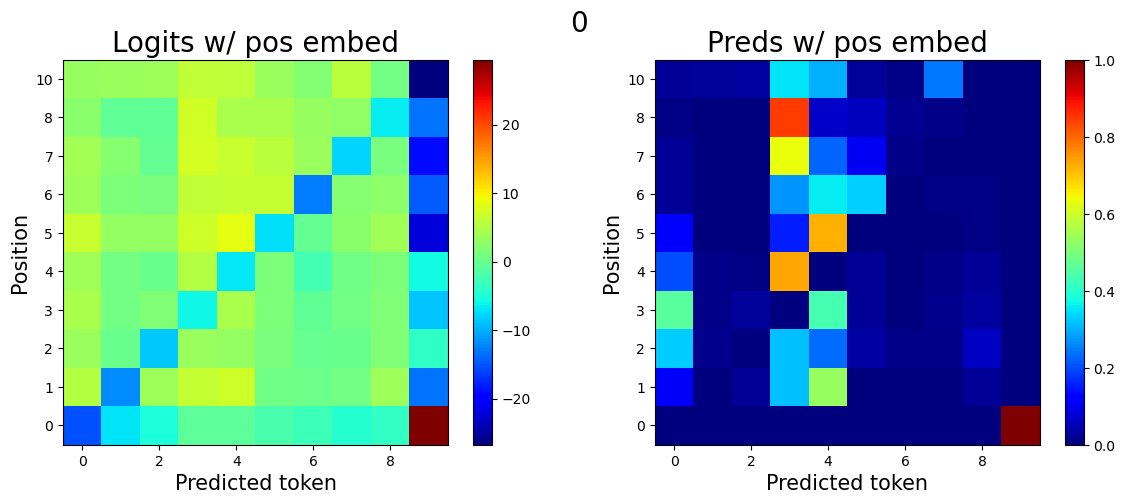

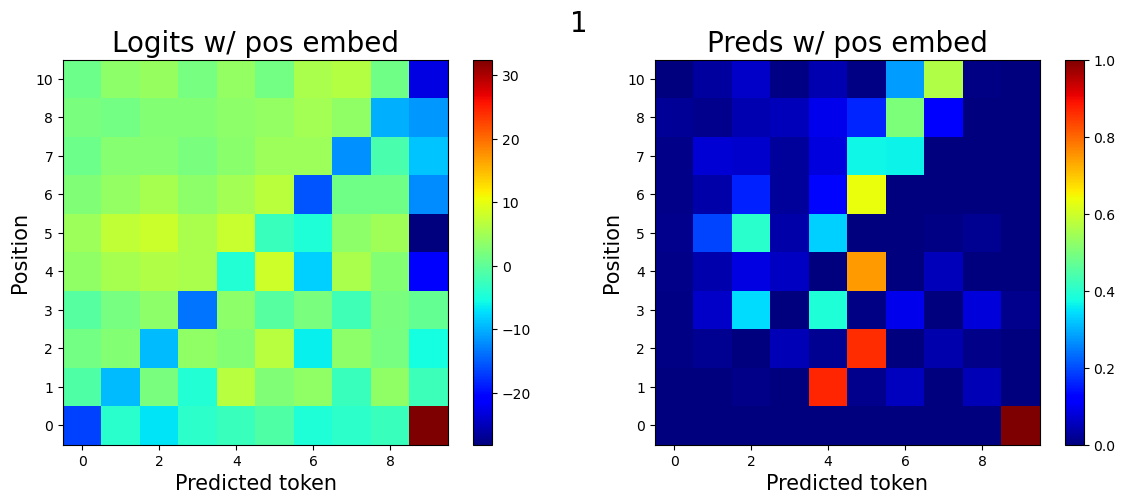

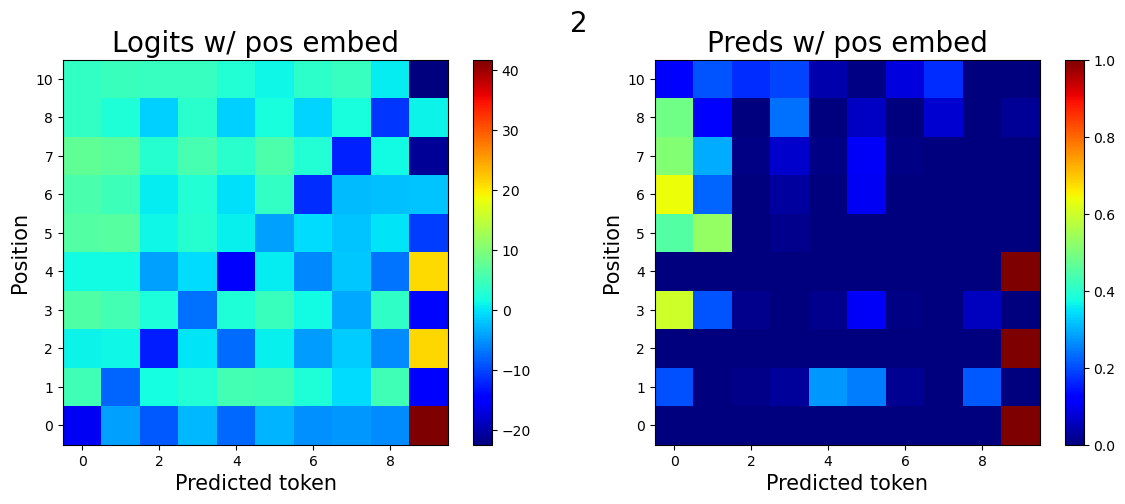

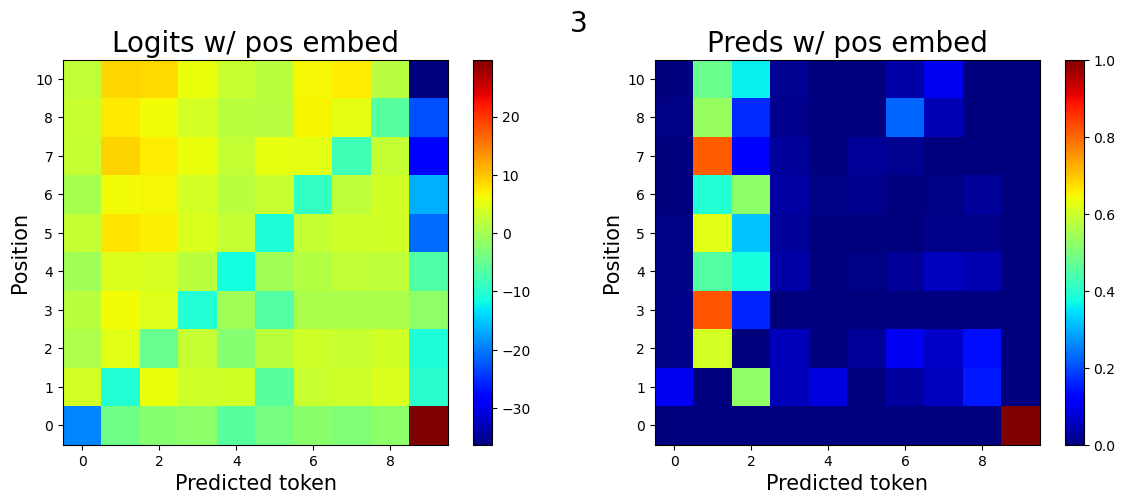

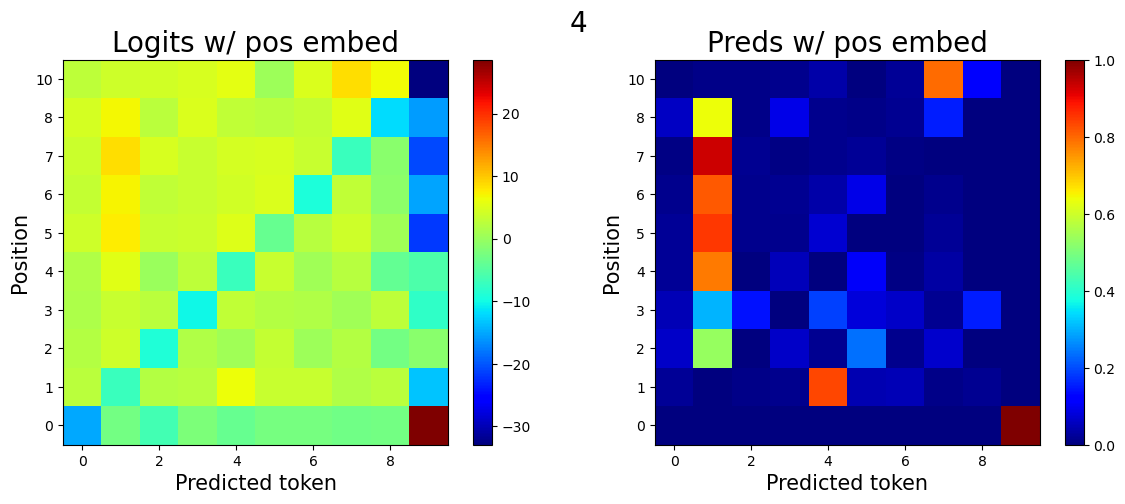

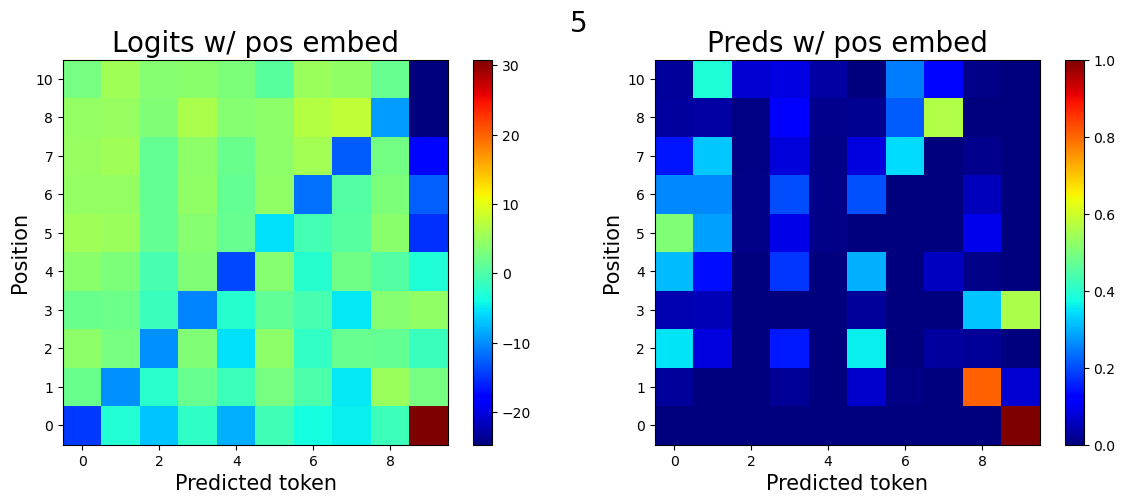

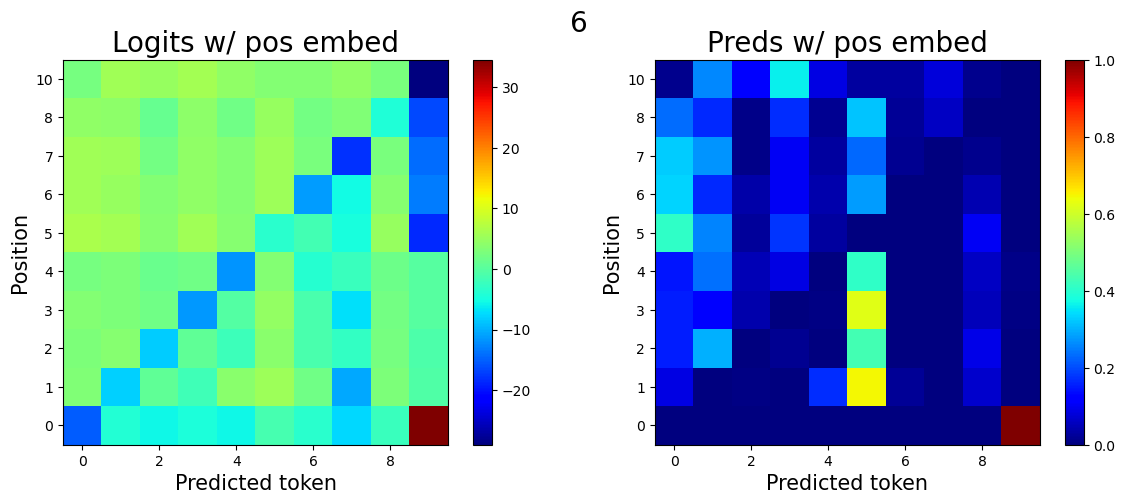

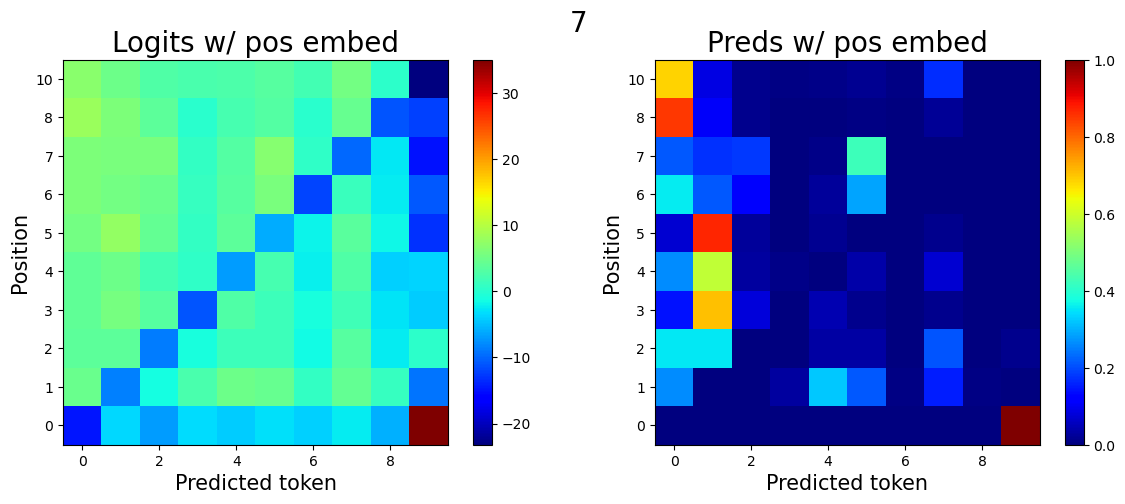

In [21]:
for i in range(8):
    plot_ablate_all_but_one_head(i, seq_bwd)

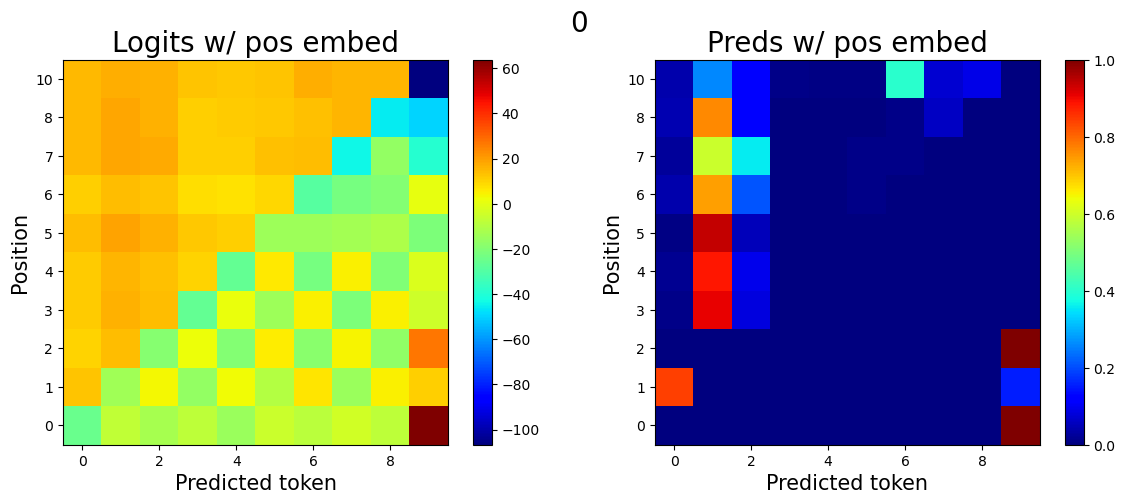

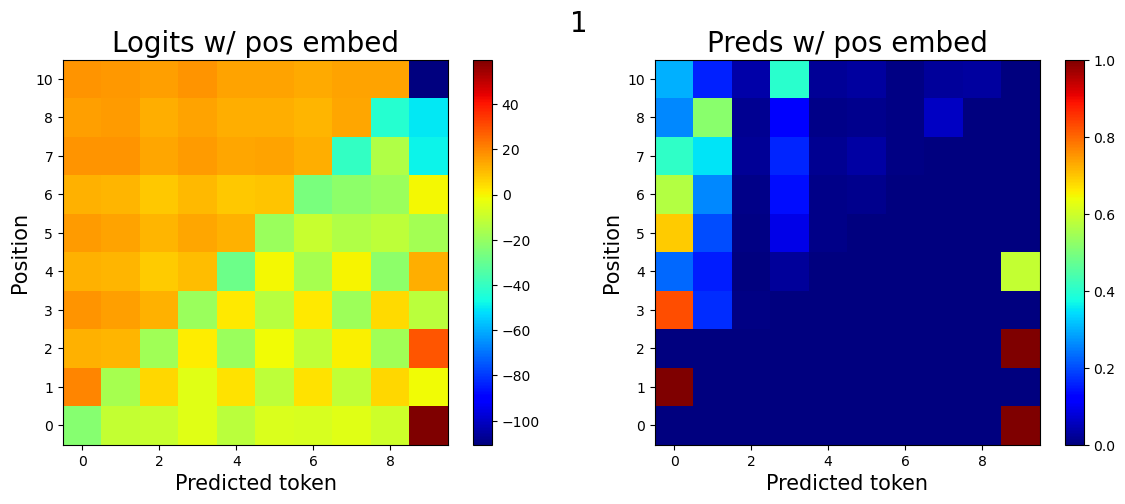

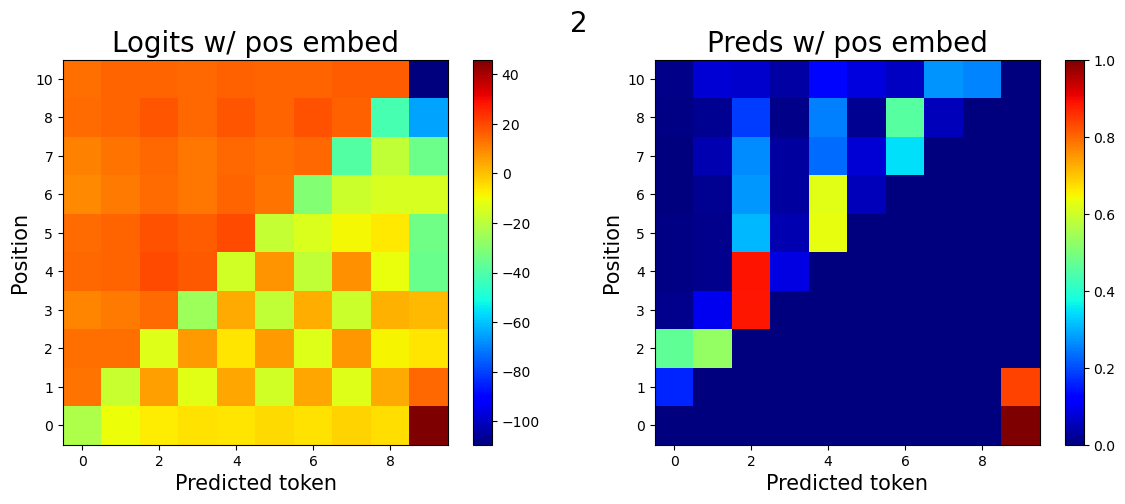

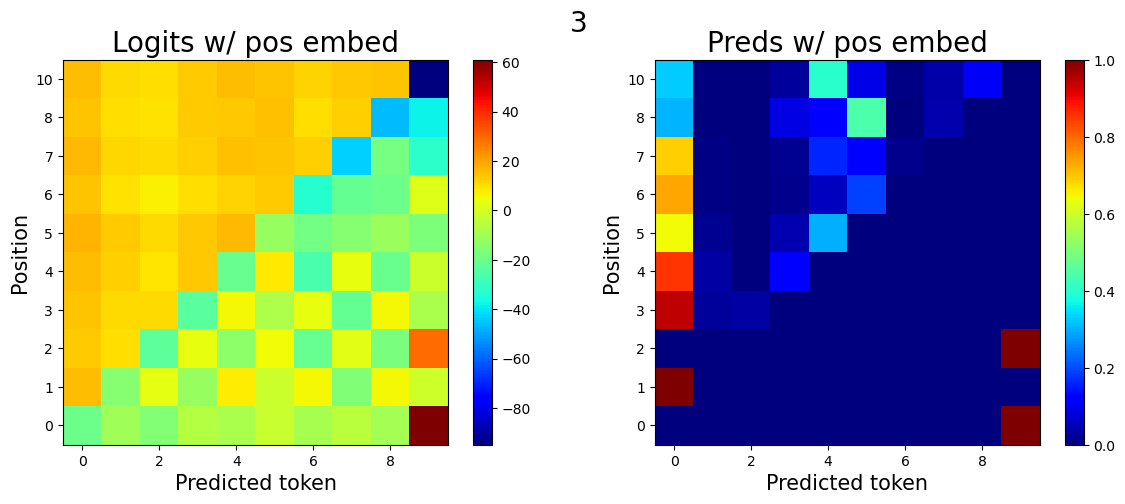

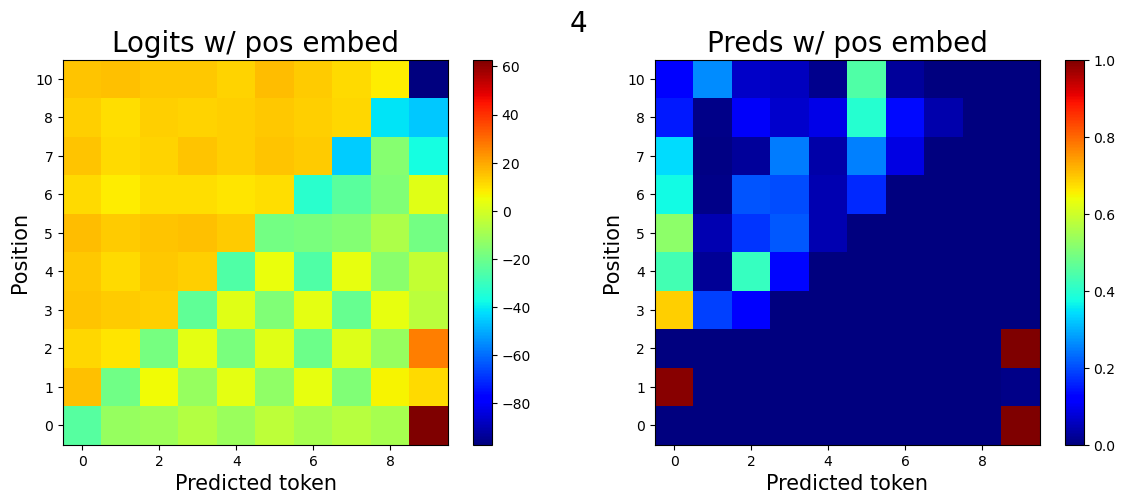

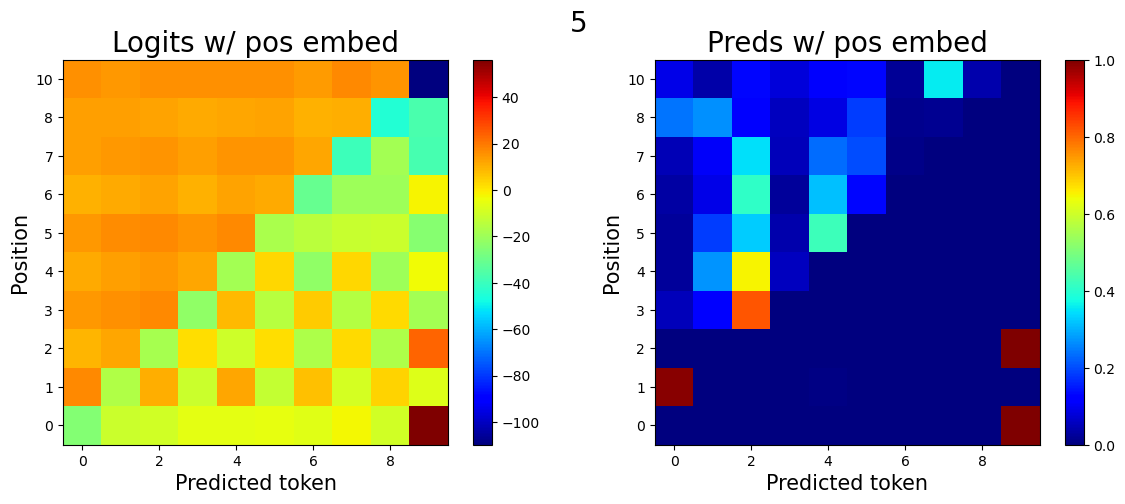

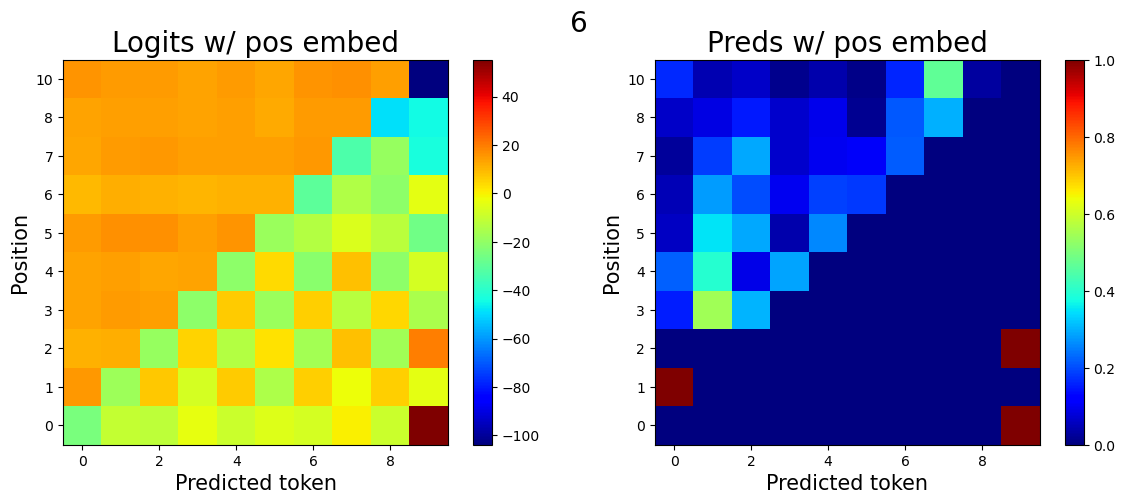

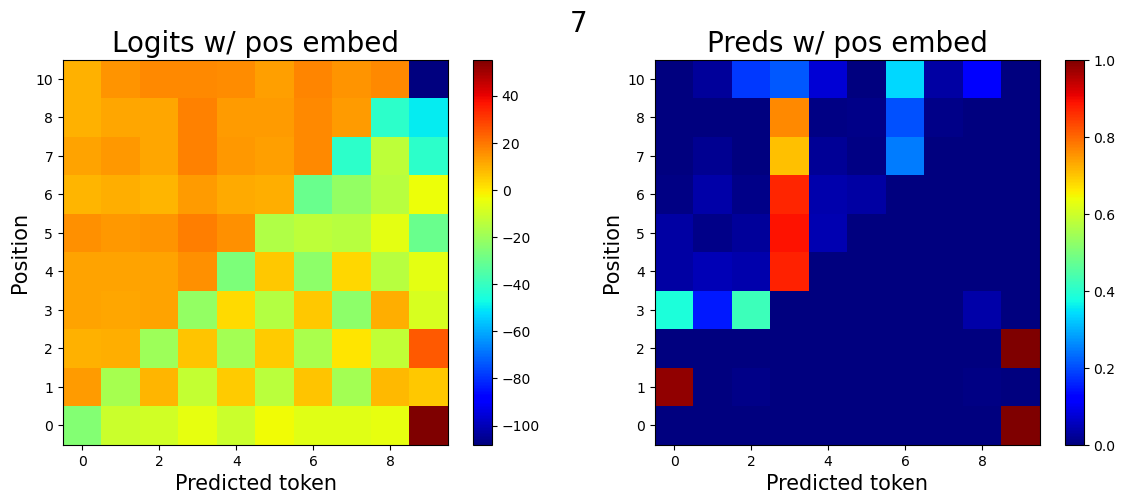

In [22]:
for i in range(8):
    plot_ablate_one_head(i, seq_bwd)

In [23]:
game.play_game(seq_bwd)

Invalid game
|   |   | X |
| O | X | O |
| X | O | X |


In [24]:
game.play_game(seq_fwd)

Invalid game
| X | O | X |
| O | X | O |
| X |   |   |


In [25]:
def plot_predictions(seq):
    plt.figure(figsize=(14, 5))

    logits = model(torch.tensor(seq))
    preds = torch.softmax(logits, axis=-1)

    plt.subplot(1, 2, 1)
    plt.imshow(numpy(logits)[0], cmap="jet")
    plt.yticks(np.arange(10), labels=seq)
    plt.ylabel("Current token", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Logits", fontsize=20)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(numpy(preds)[0], cmap="jet")
    plt.yticks(np.arange(10), labels=seq)
    plt.ylabel("Current token", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Preds", fontsize=20)
    plt.colorbar()

    plt.show()

In [26]:
opposite_diag = [10, 0, 1, 4, 2, 8, 9, 9, 9, 9]
game.play_game(opposite_diag)

Invalid game
| X | O | O |
|   | X |   |
|   |   | X |


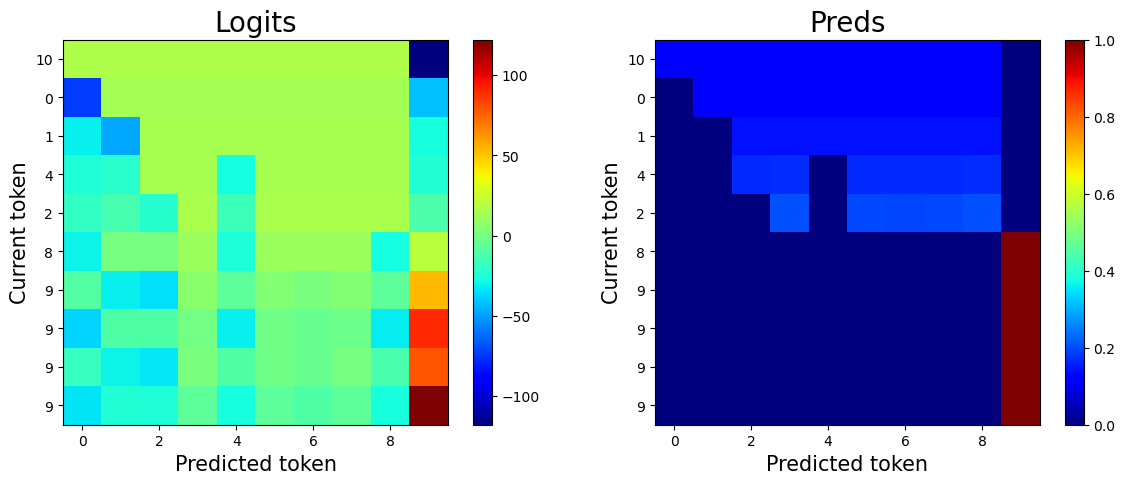

In [27]:
plot_predictions(opposite_diag)

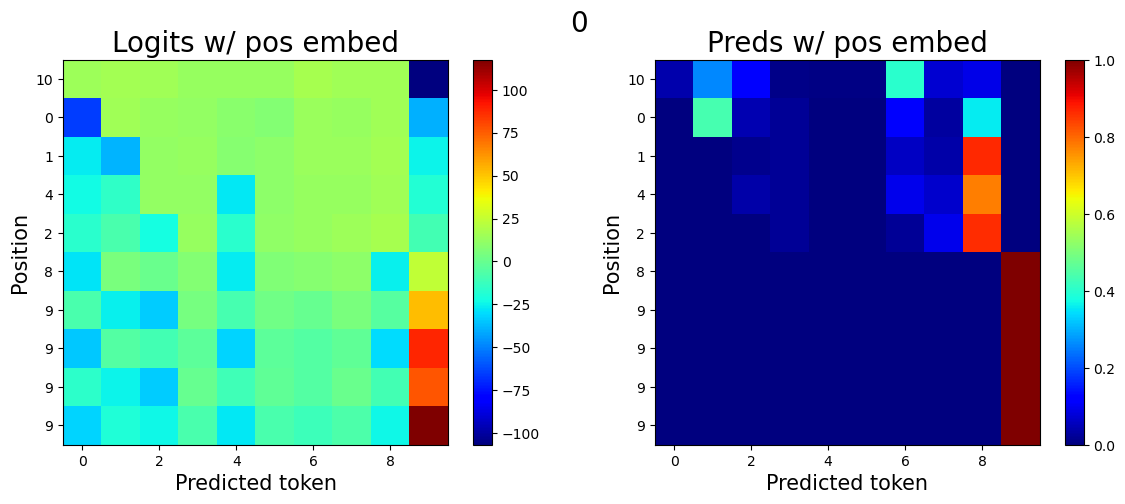

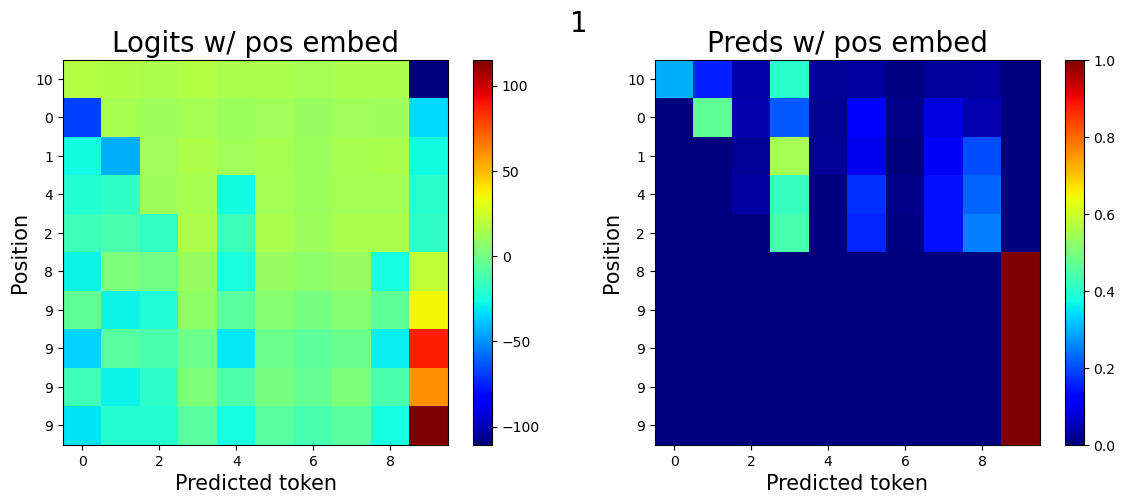

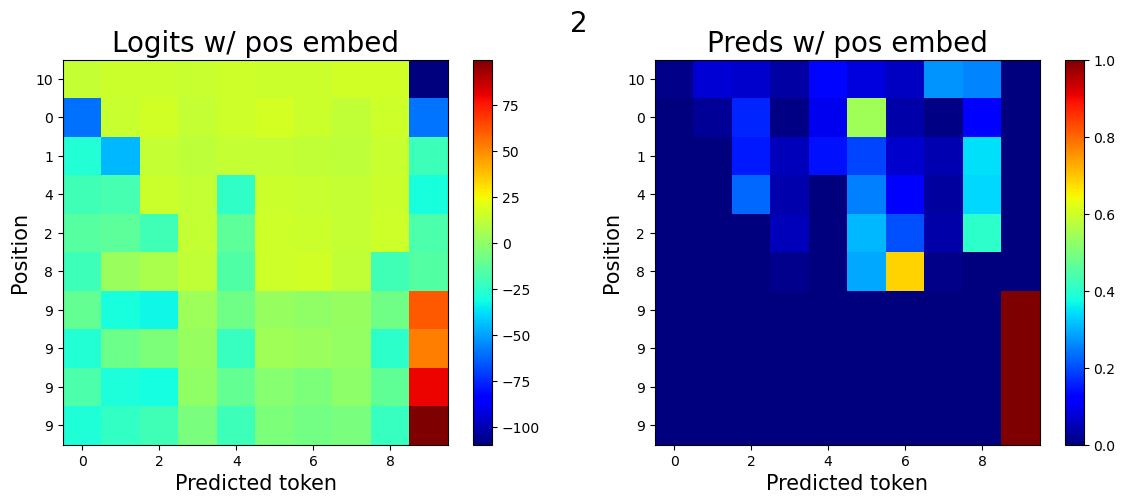

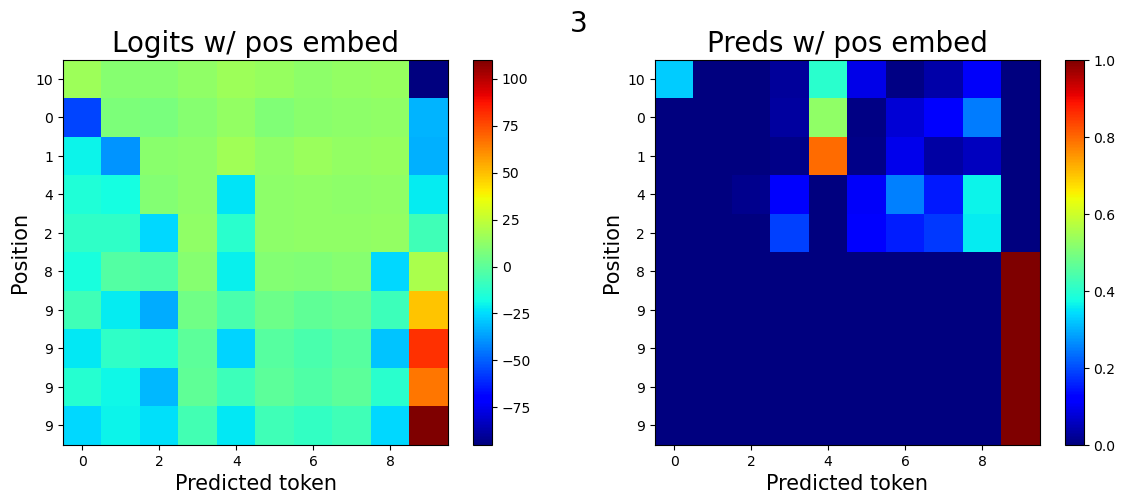

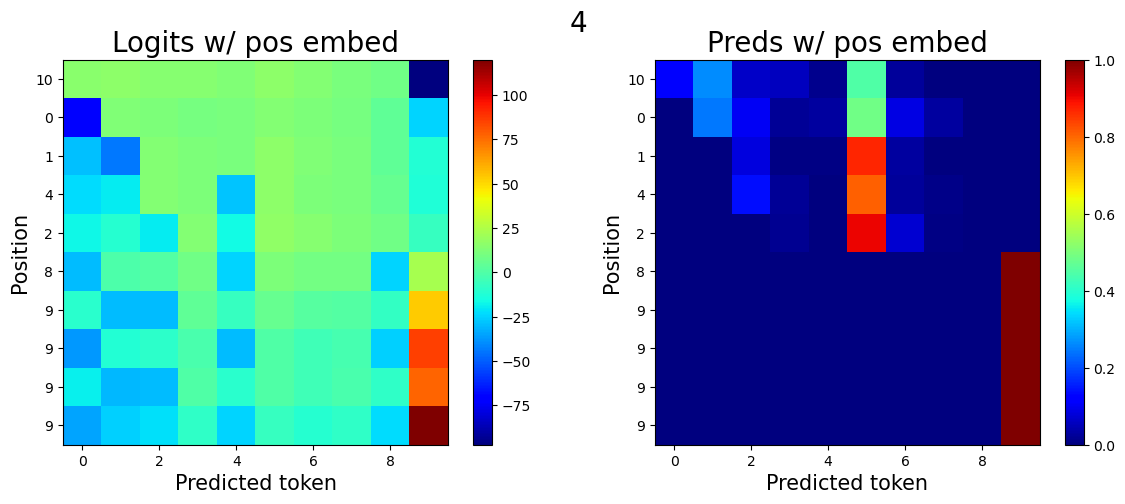

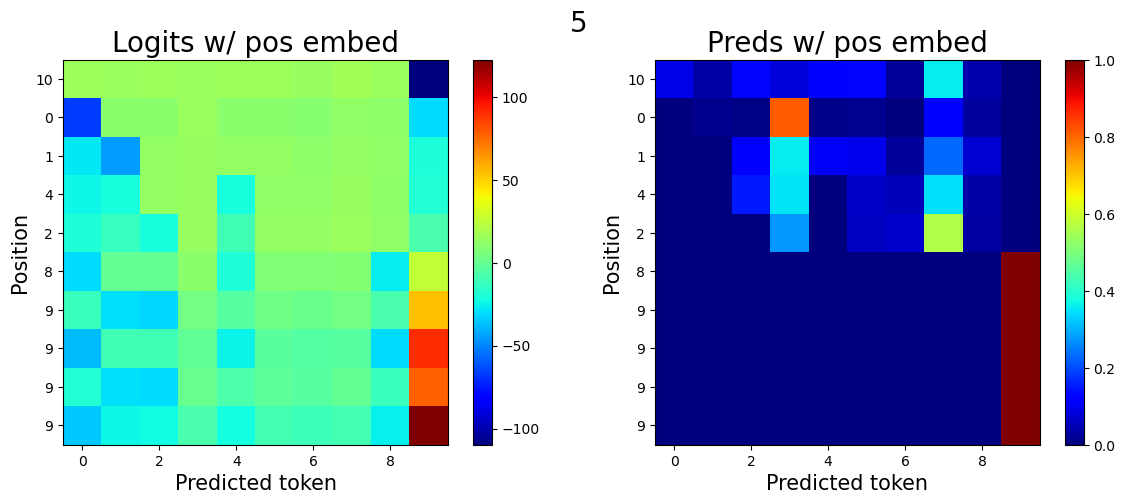

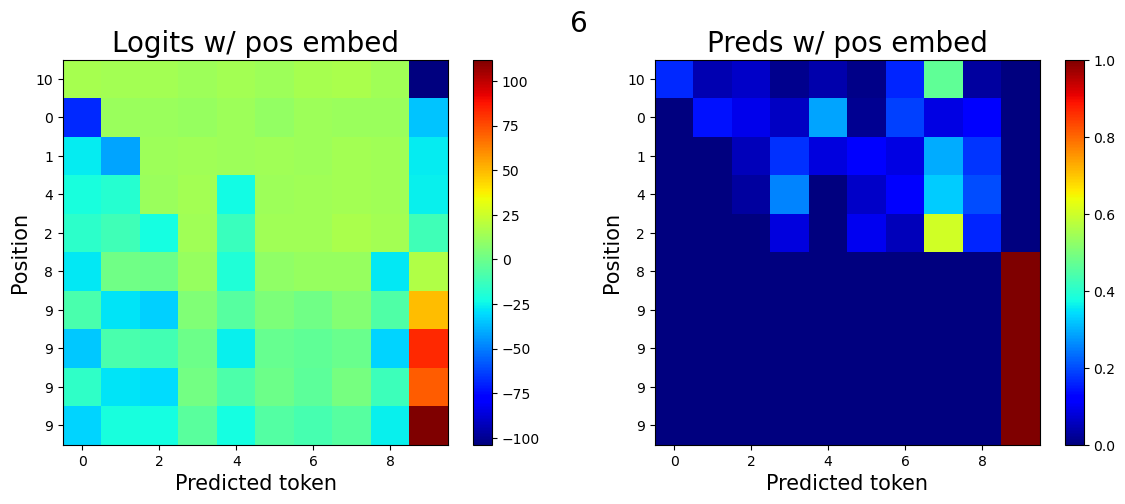

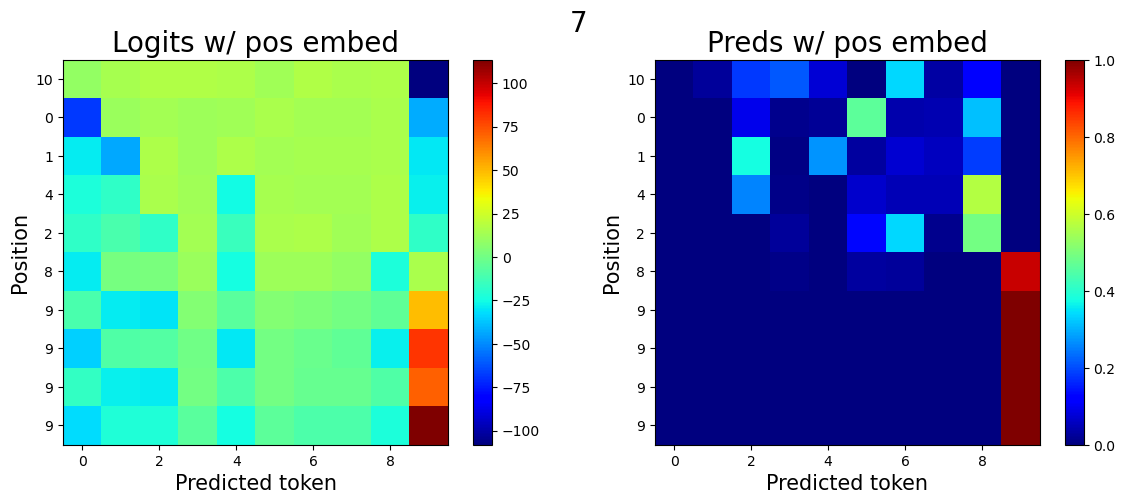

In [28]:
for i in range(8):
    plot_ablate_one_head(i, opposite_diag)

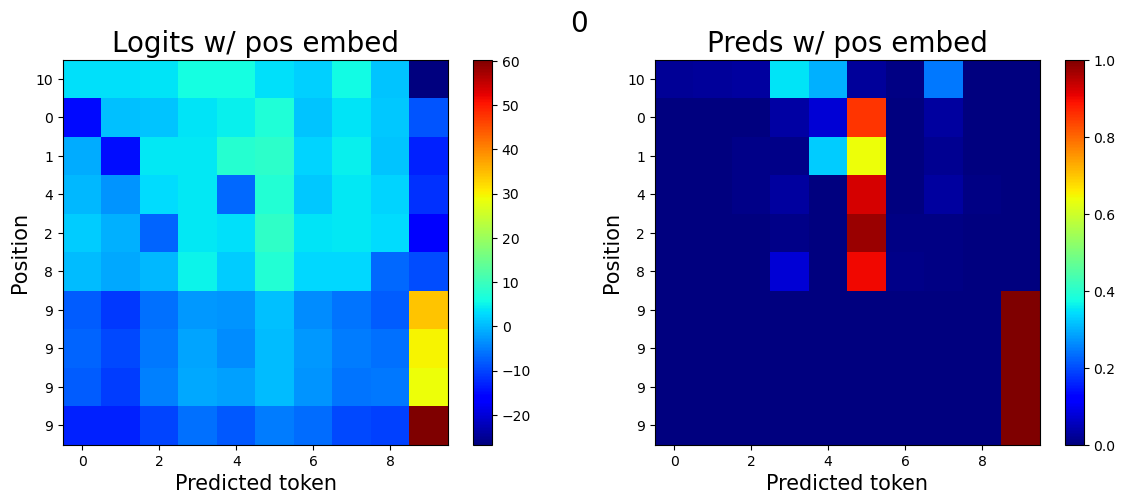

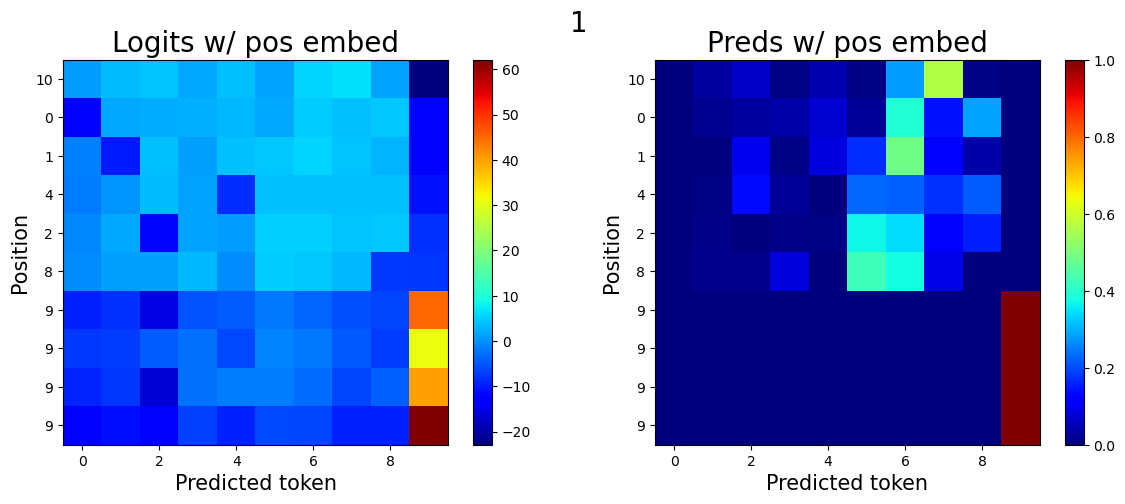

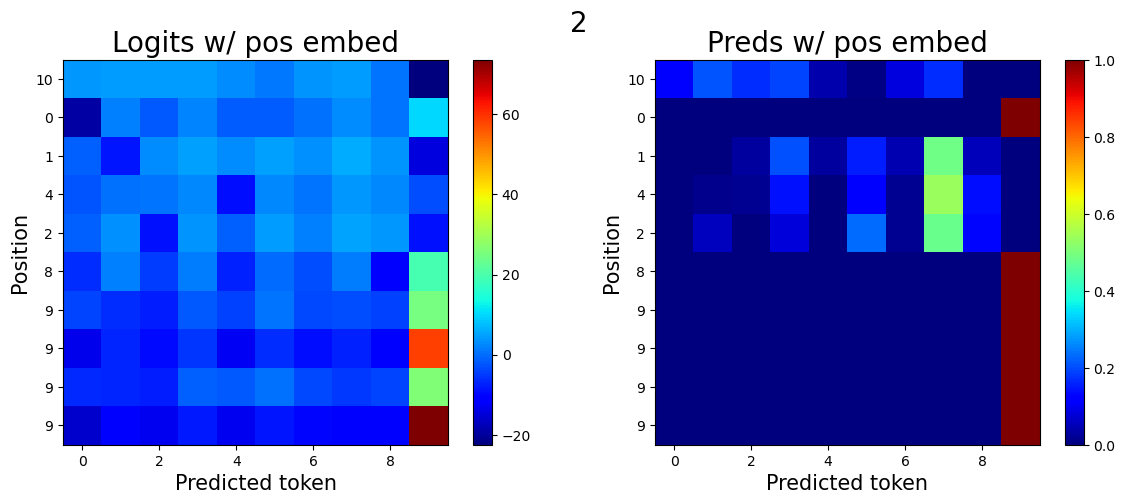

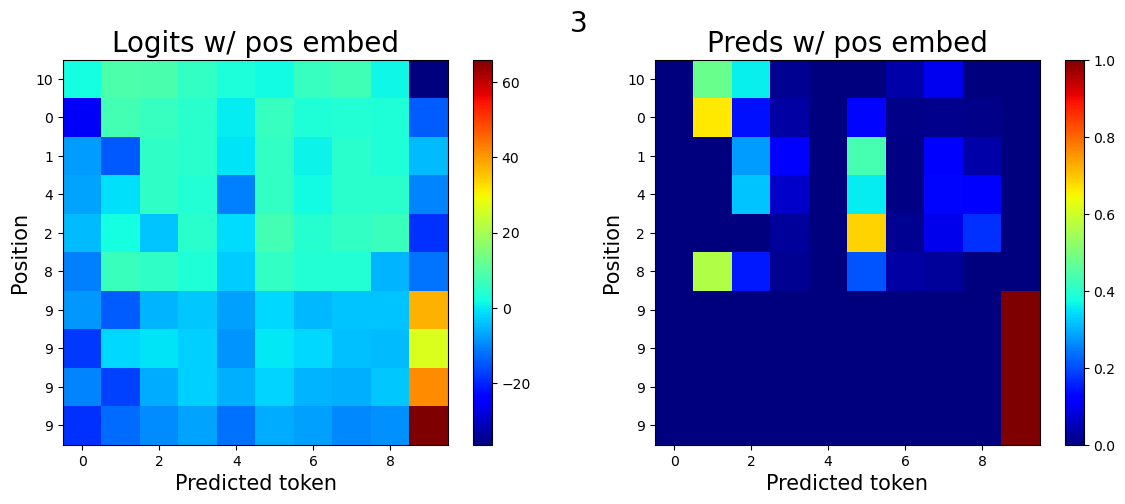

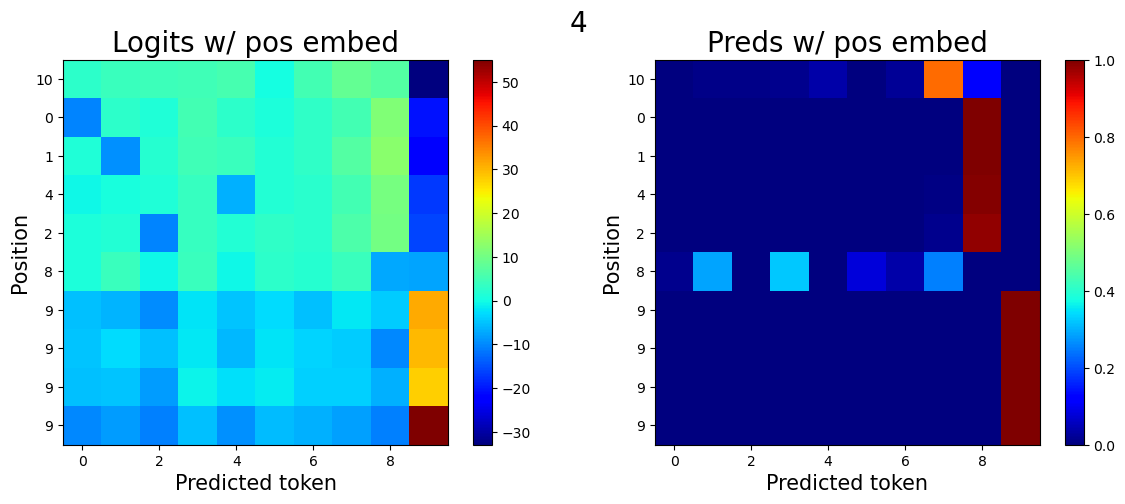

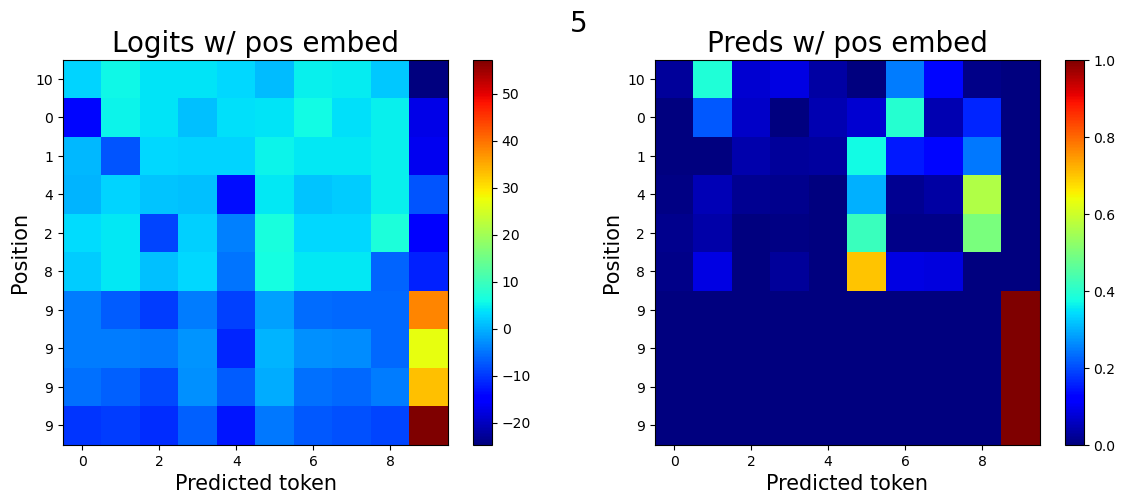

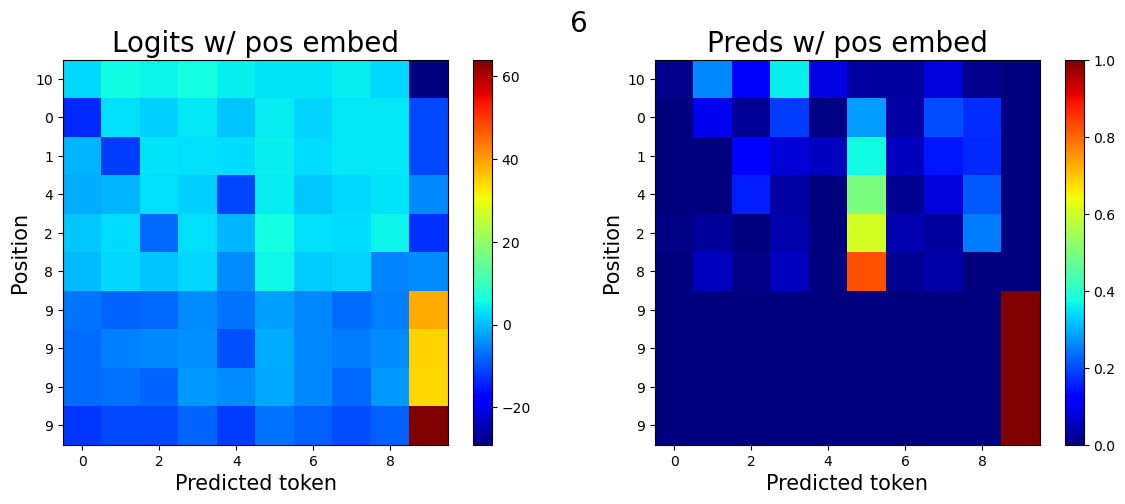

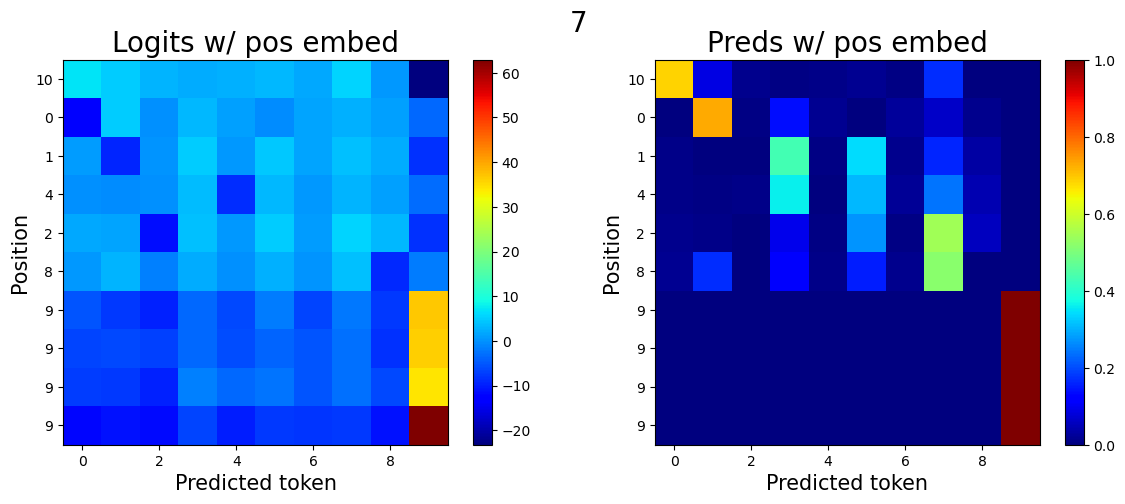

In [29]:
for i in range(8):
    plot_ablate_all_but_one_head(i, opposite_diag)

In [30]:
left_vert = [10, 0, 1, 3, 2, 6, 9, 9, 9, 9]
game.play_game(left_vert)

Invalid game
| X | O | O |
| X |   |   |
| X |   |   |


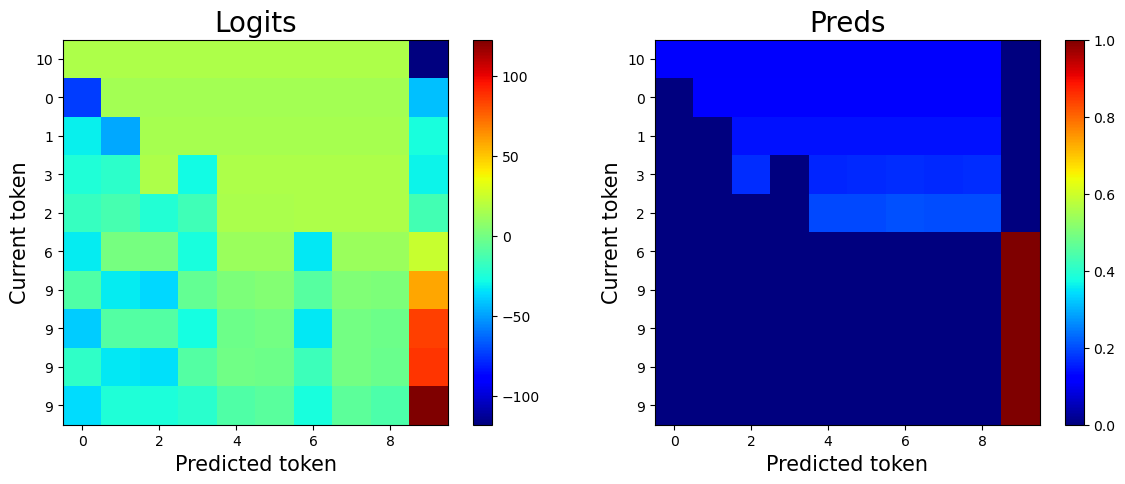

In [31]:
plot_predictions(left_vert)

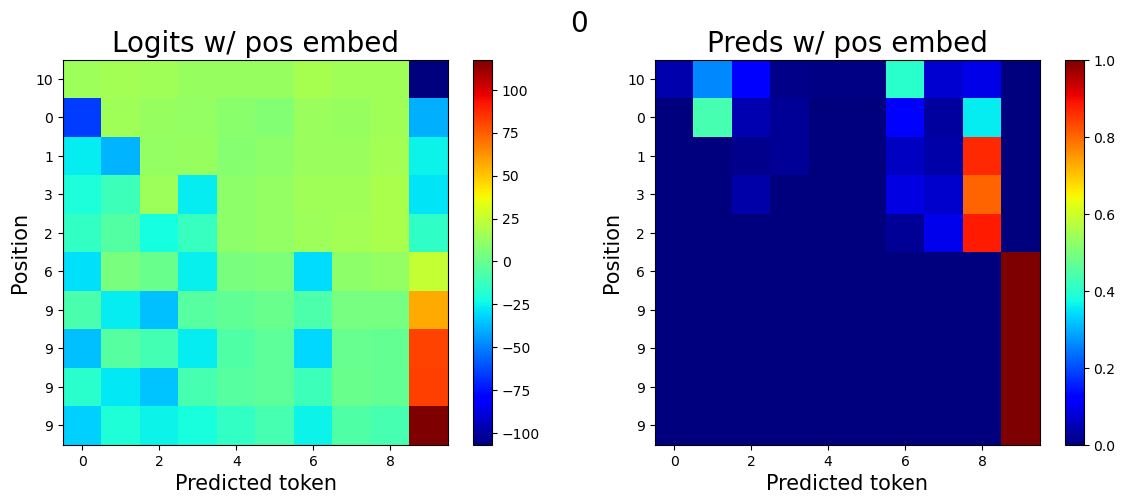

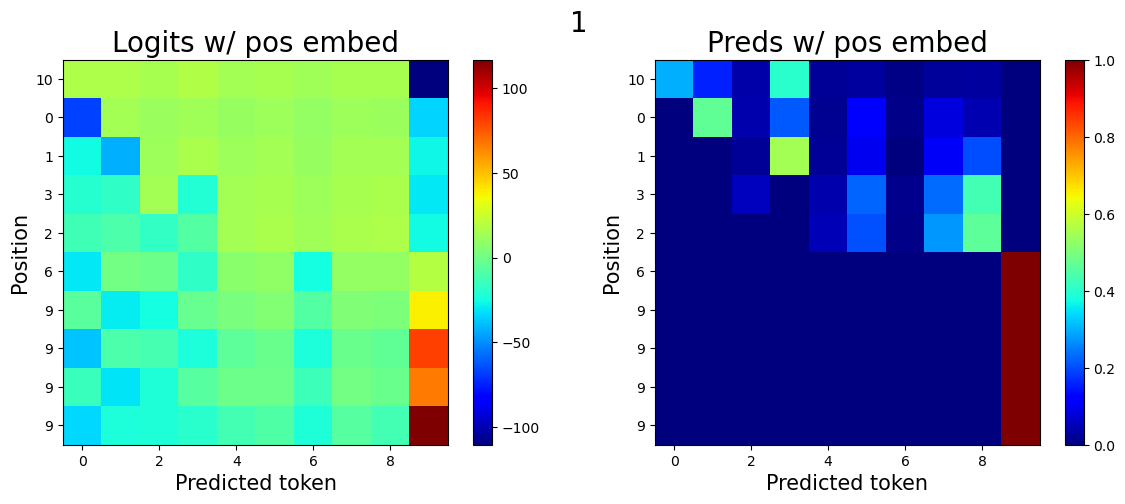

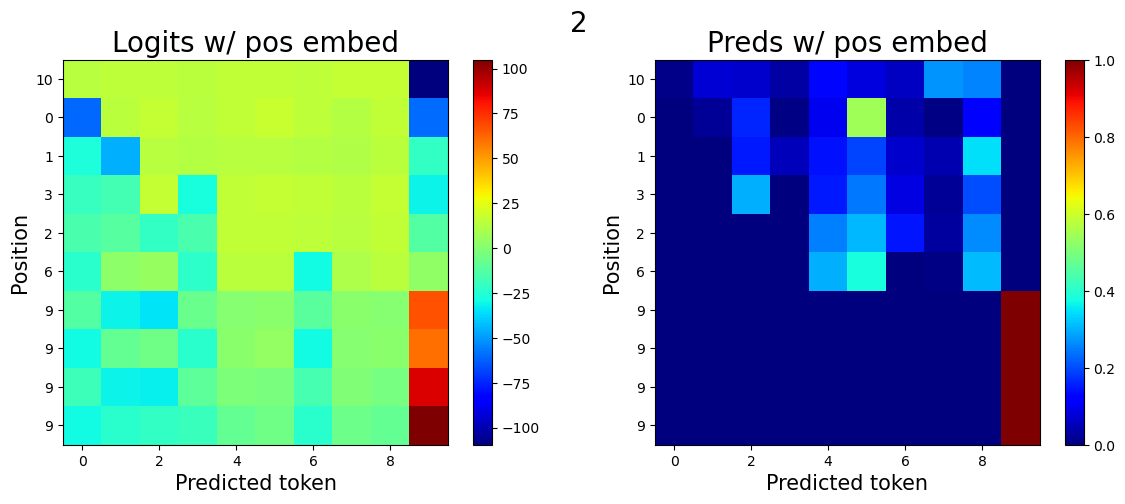

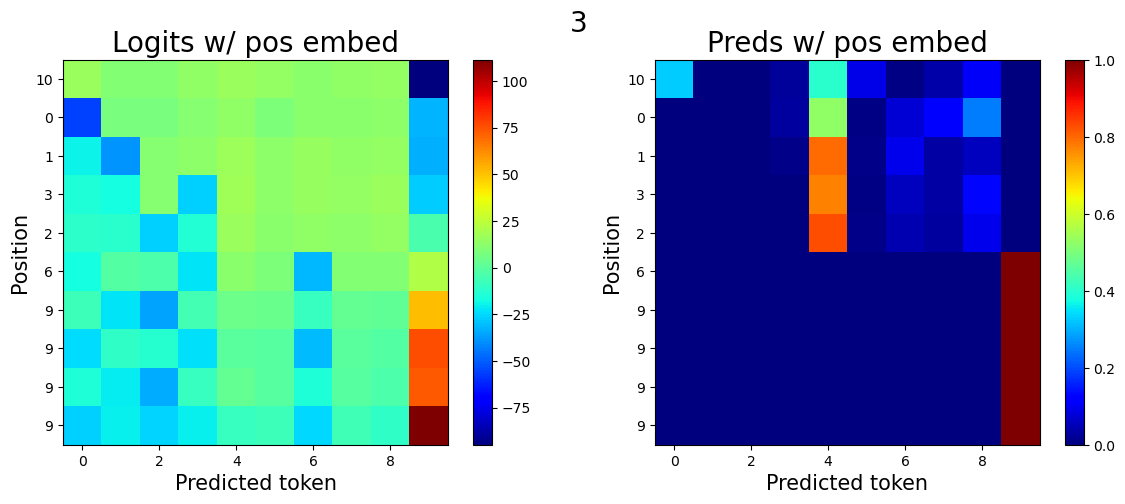

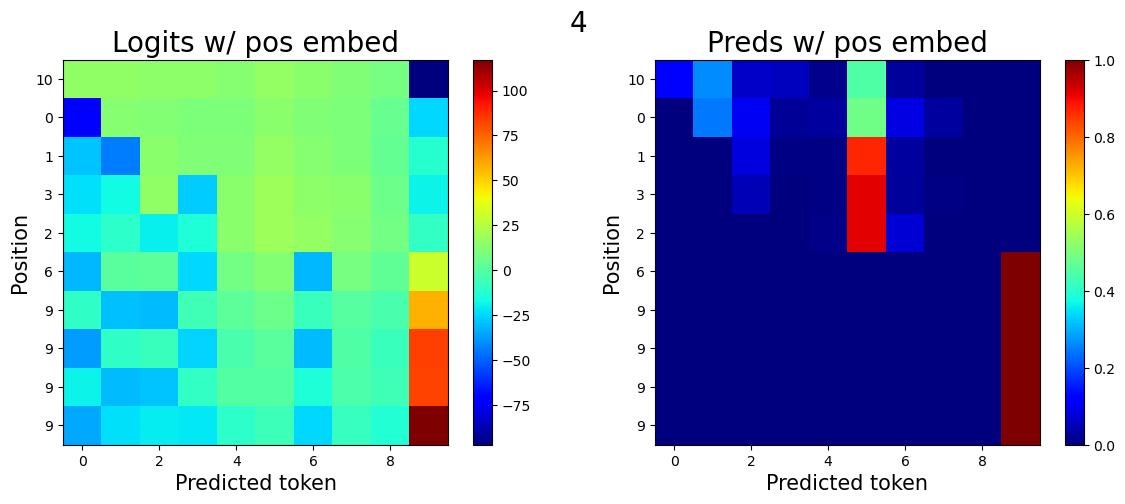

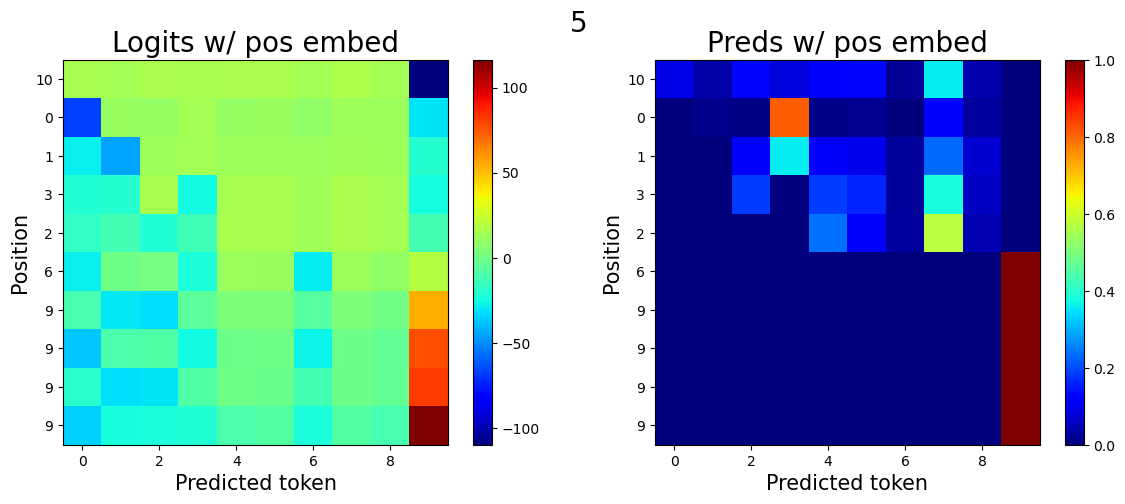

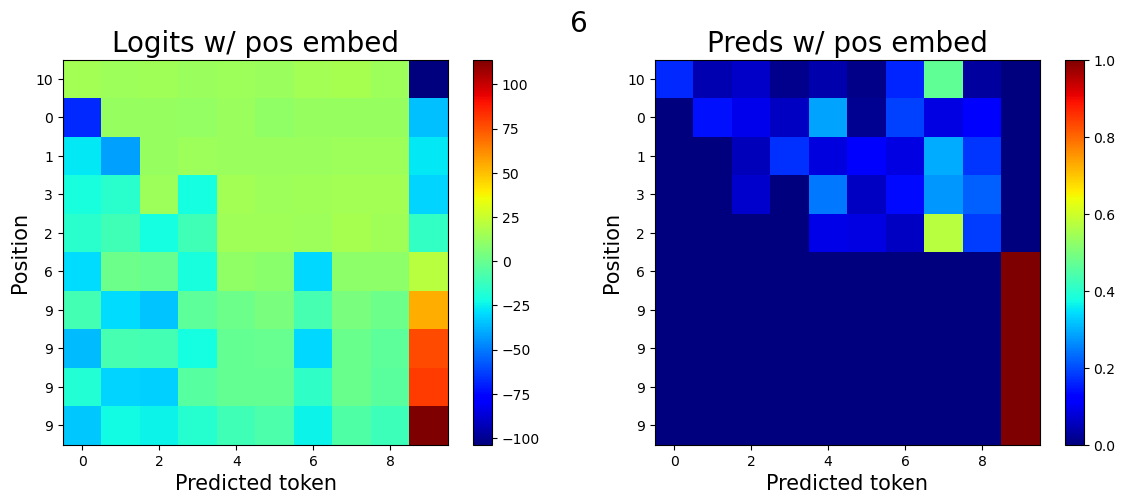

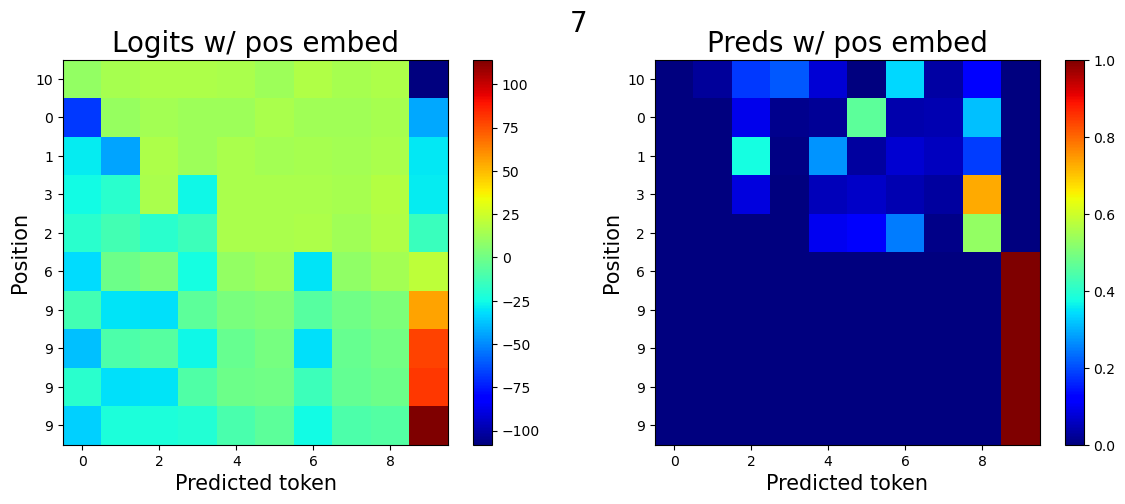

In [32]:
for i in range(8):
    plot_ablate_one_head(i, left_vert)

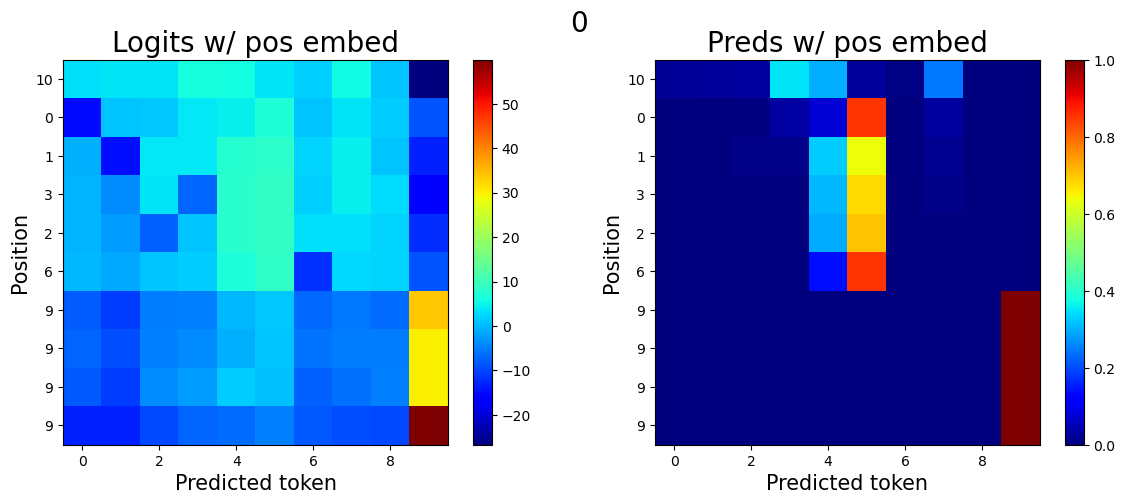

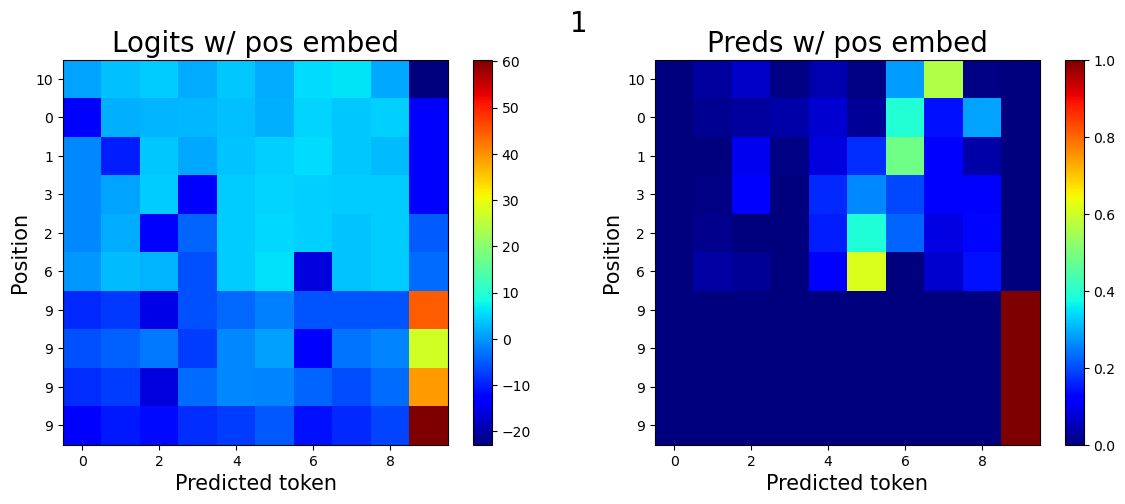

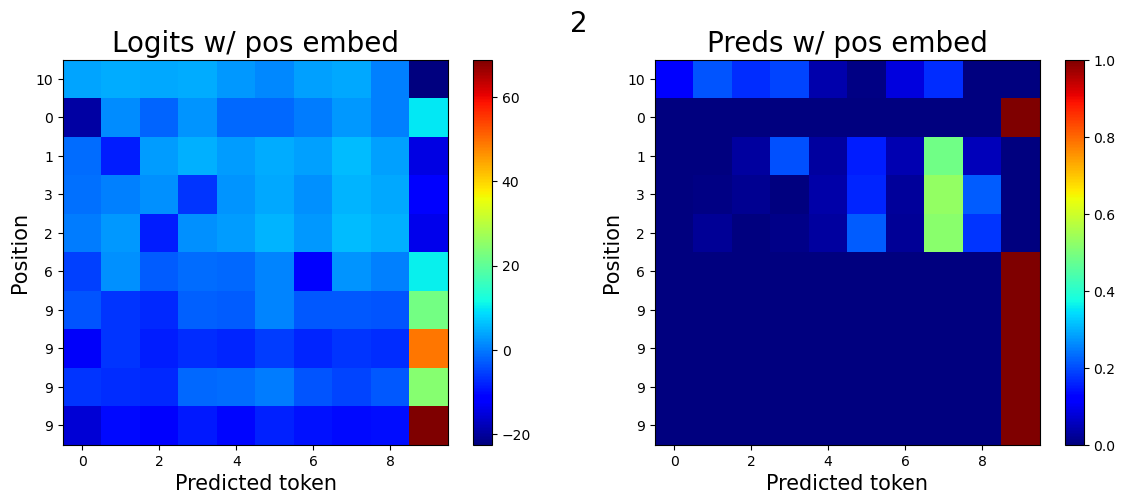

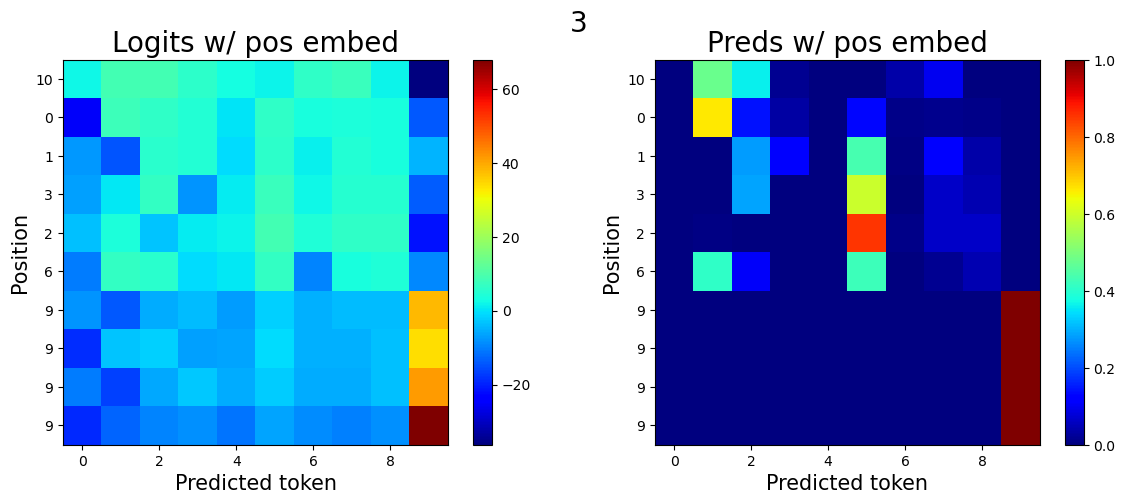

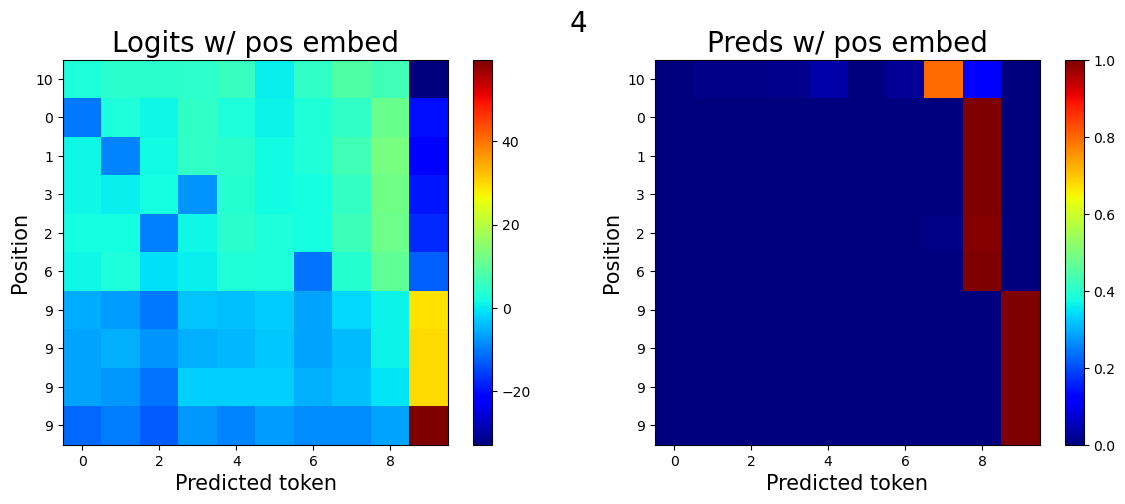

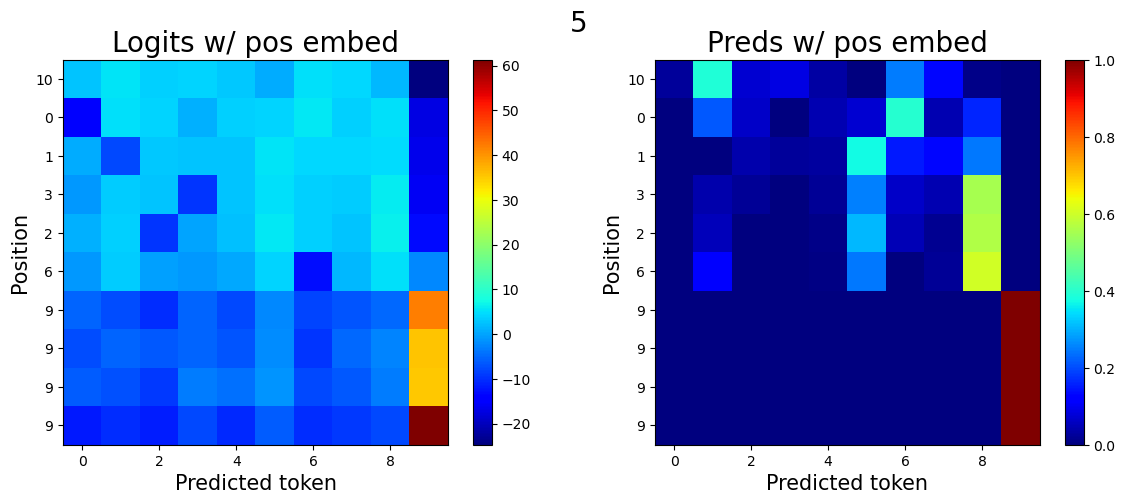

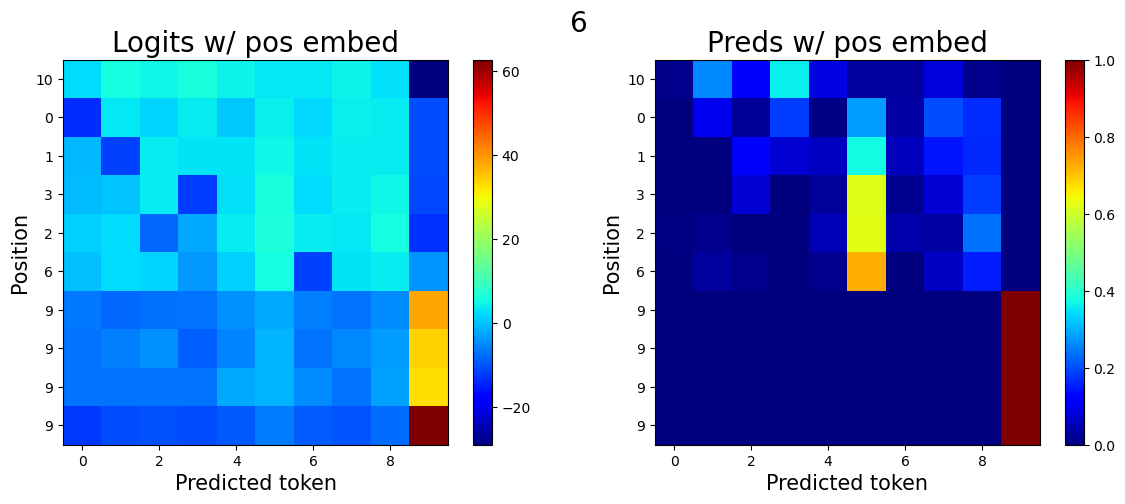

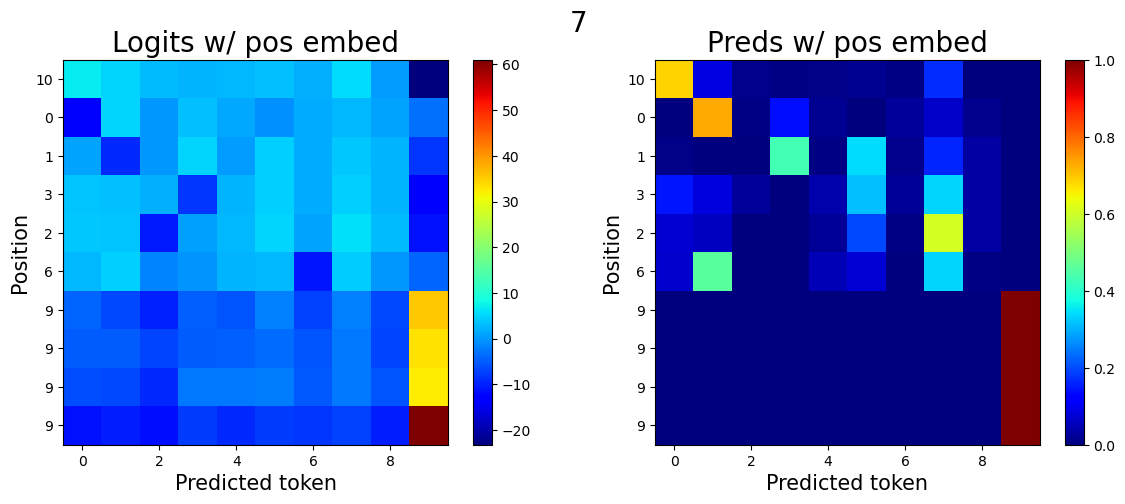

In [33]:
for i in range(8):
    plot_ablate_all_but_one_head(i, left_vert)

In [34]:
bottom_row = [10, 8, 0, 7, 1, 6, 9, 9, 9, 9]
game.play_game(bottom_row)

Invalid game
| O | O |   |
|   |   |   |
| X | X | X |


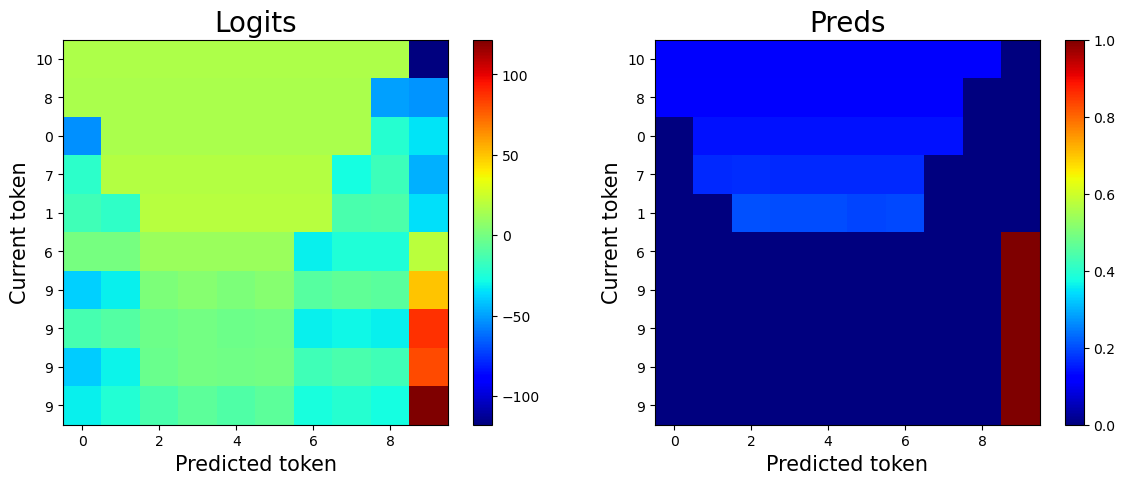

In [35]:
plot_predictions(bottom_row)

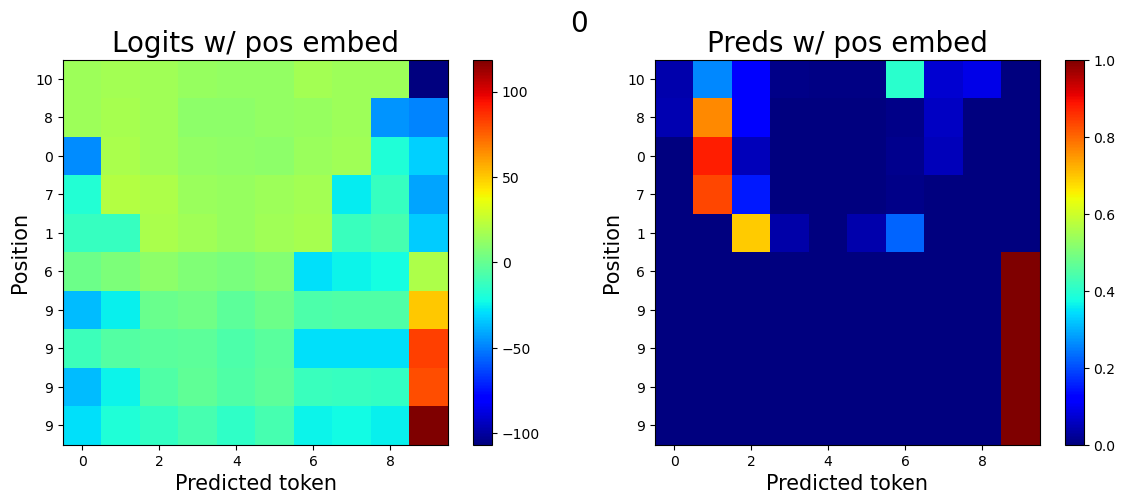

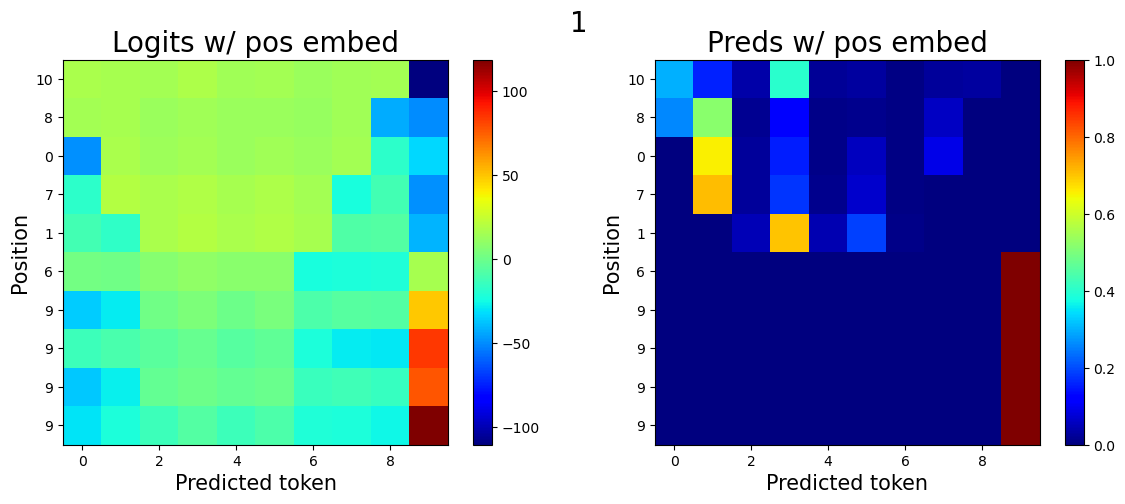

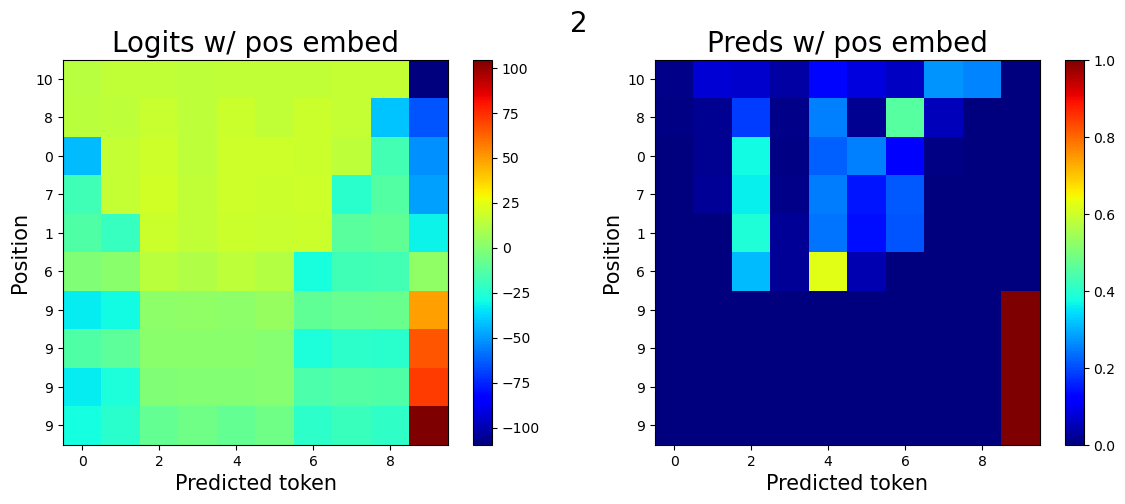

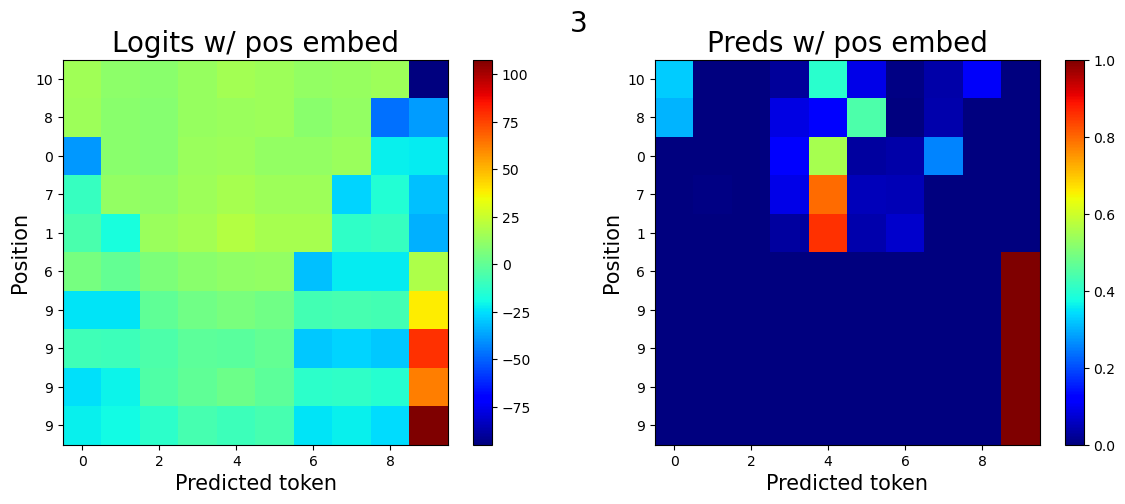

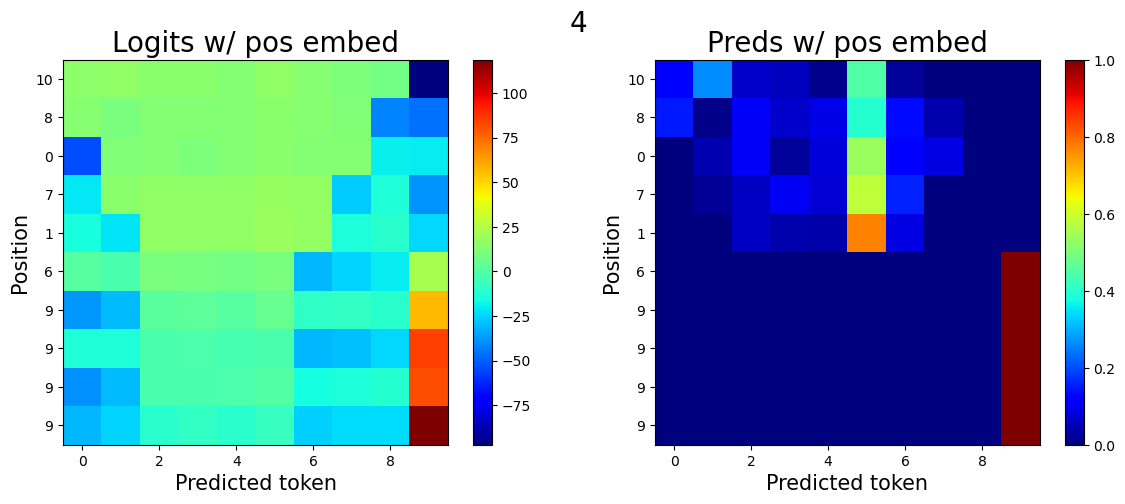

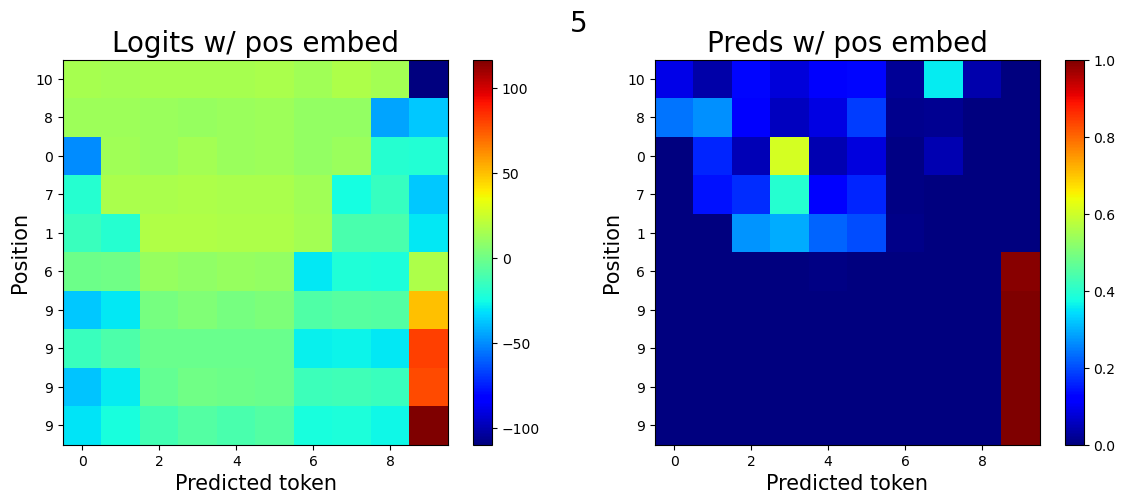

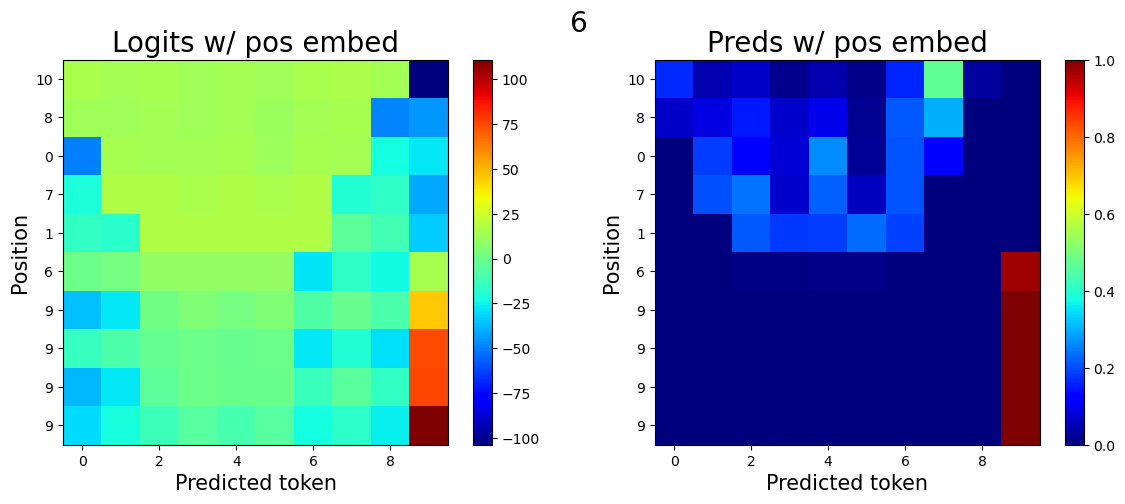

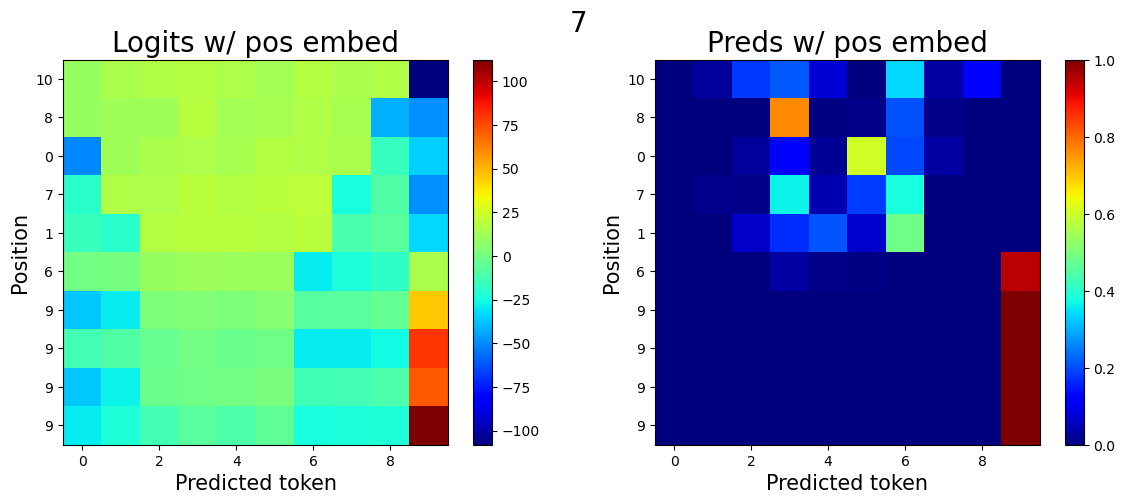

In [36]:
for i in range(8):
    plot_ablate_one_head(i, bottom_row)

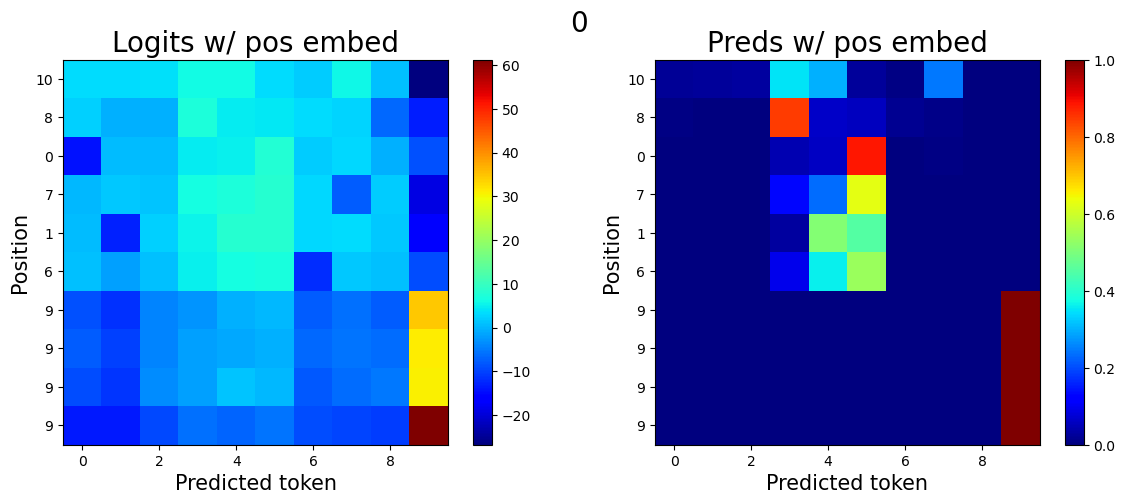

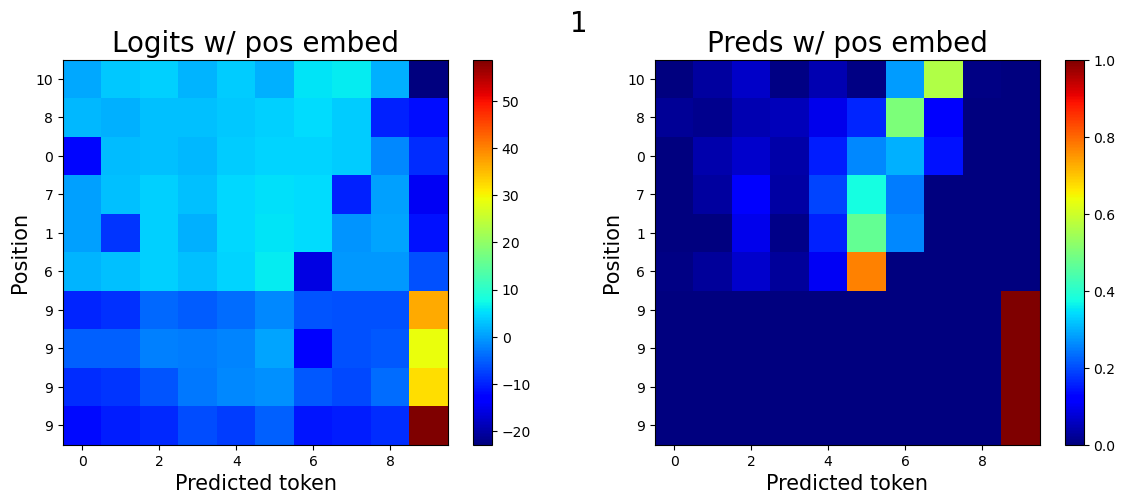

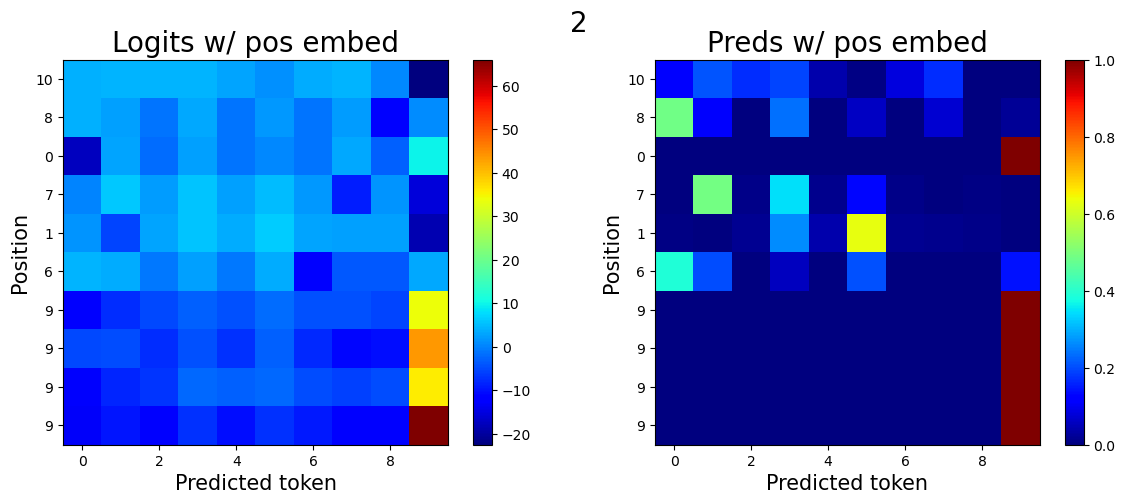

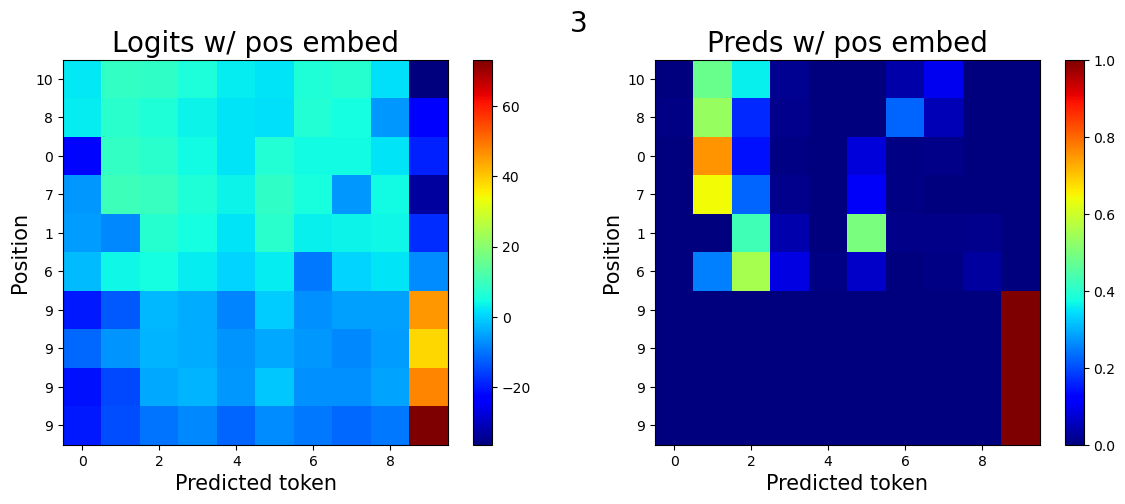

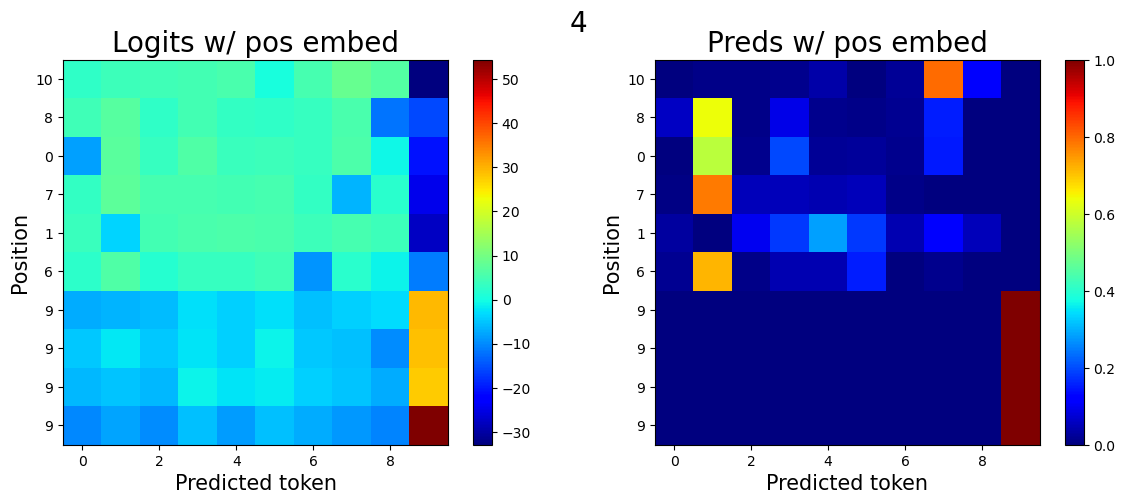

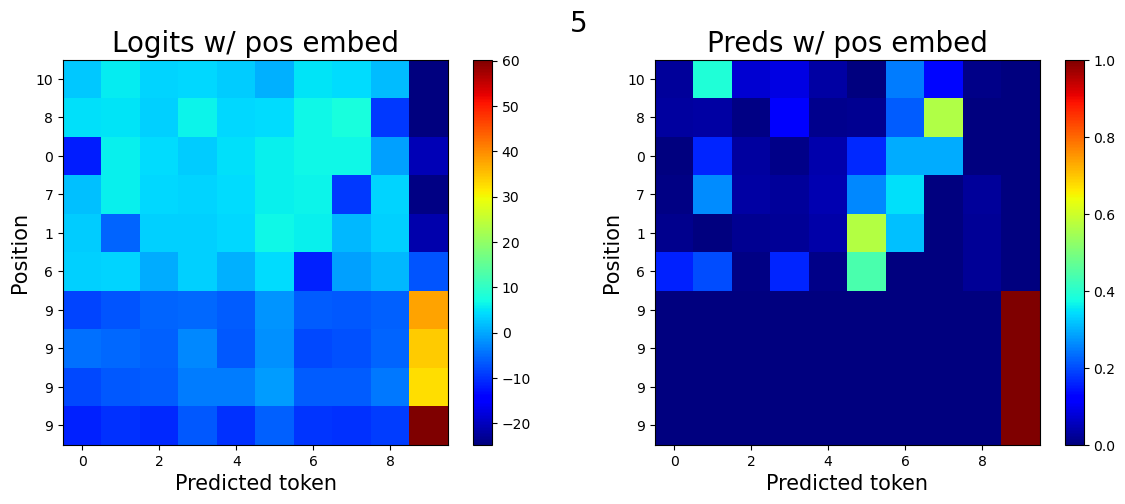

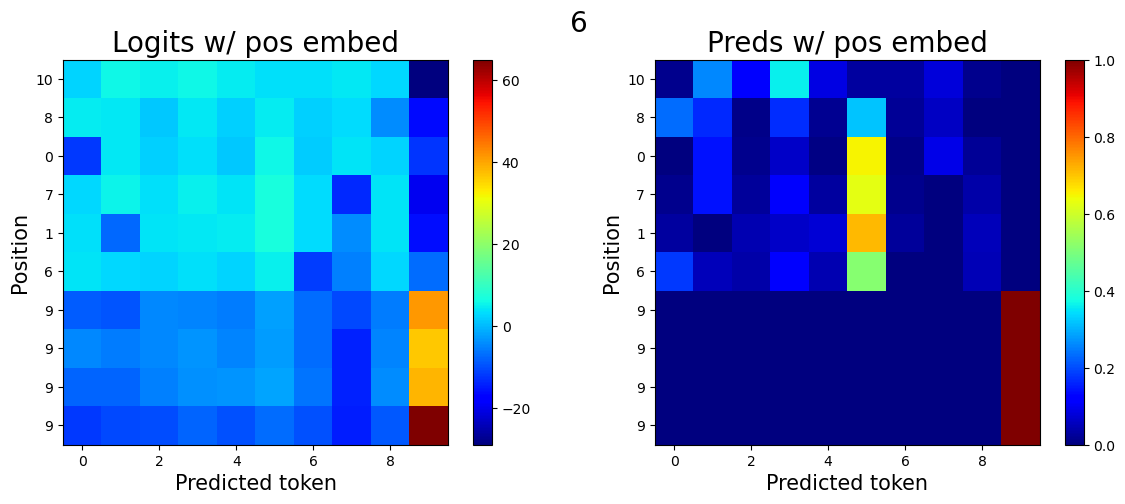

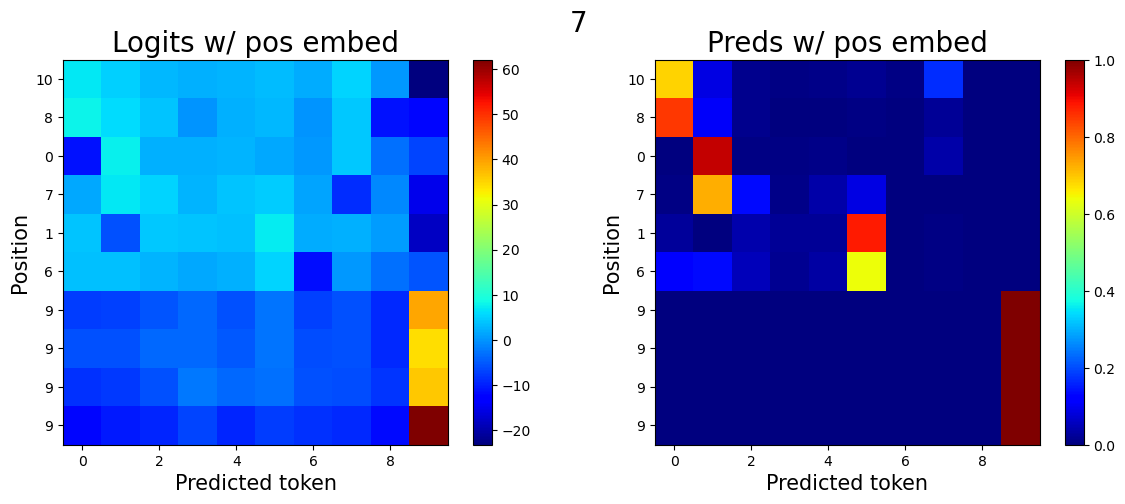

In [37]:
for i in range(8):
    plot_ablate_all_but_one_head(i, bottom_row)

In [41]:
def ablate_mlp(seq):
    def hook(module, input, output):
        return torch.zeros_like(output)

    try:
        handle = model.blocks[0].mlp.register_forward_hook(hook)
        logits = model(torch.tensor(seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits

In [53]:
def plot_predictions(seq, logits, **kwargs):
    plt.figure(figsize=(14, 5))

    preds = torch.softmax(logits, axis=-1)

    plt.subplot(1, 2, 1)
    plt.imshow(numpy(logits)[0], cmap="jet", **kwargs)
    plt.yticks(np.arange(10), labels=seq)
    plt.ylabel("Current token", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Logits", fontsize=20)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(numpy(preds)[0], cmap="jet", vmin=0, vmax=1)
    plt.yticks(np.arange(10), labels=seq)
    plt.ylabel("Current token", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Preds", fontsize=20)
    plt.colorbar()

    plt.show()

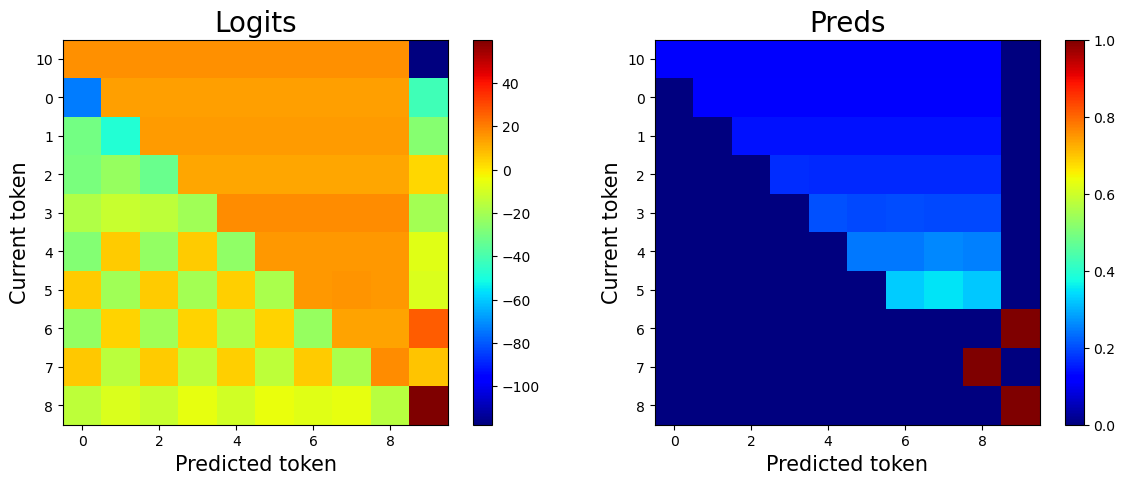

In [54]:
plot_predictions(seq_fwd, model(torch.tensor(seq_fwd)))

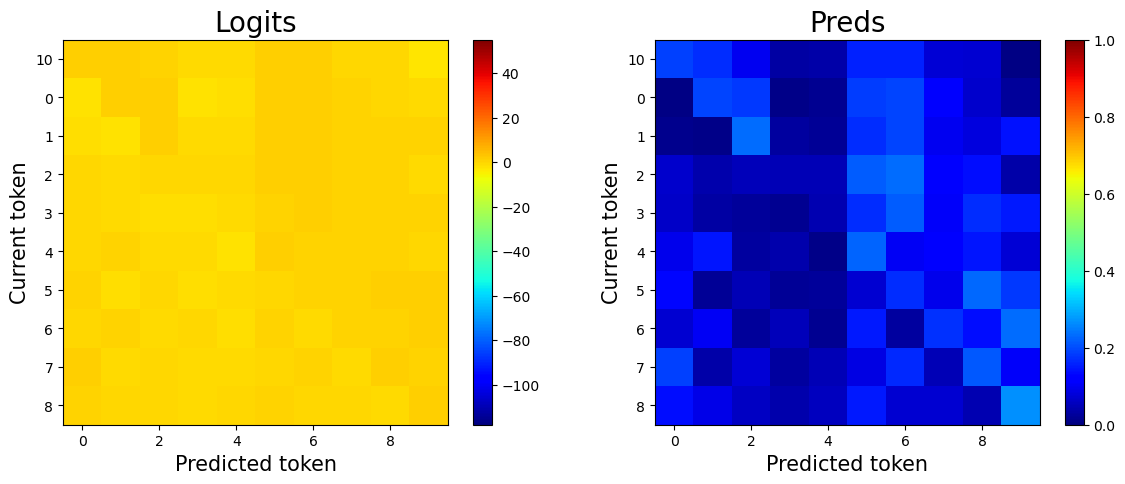

In [55]:
plot_predictions(seq_fwd, ablate_mlp(seq_fwd), vmax=55, vmin=-118)

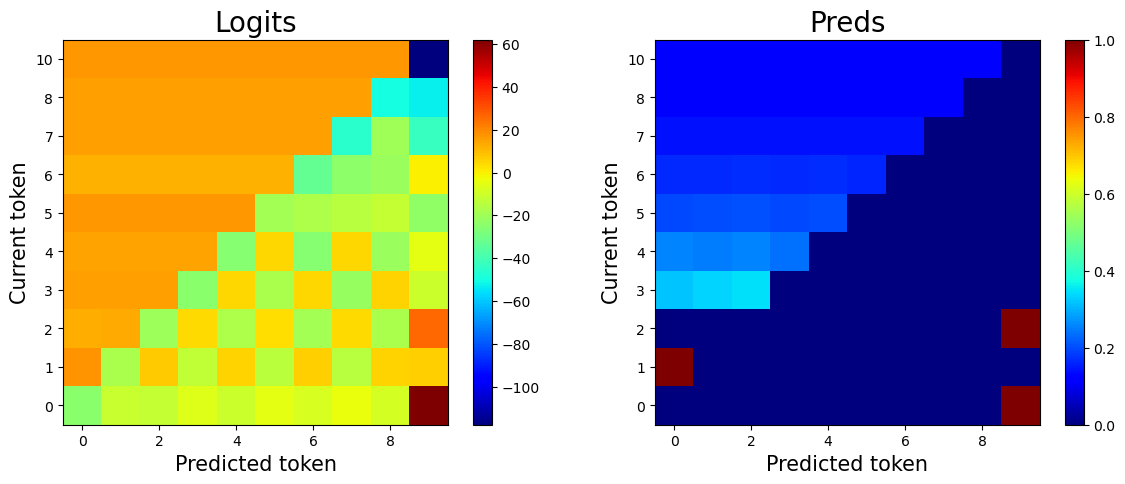

In [46]:
plot_predictions(seq_bwd, model(torch.tensor(seq_bwd)))

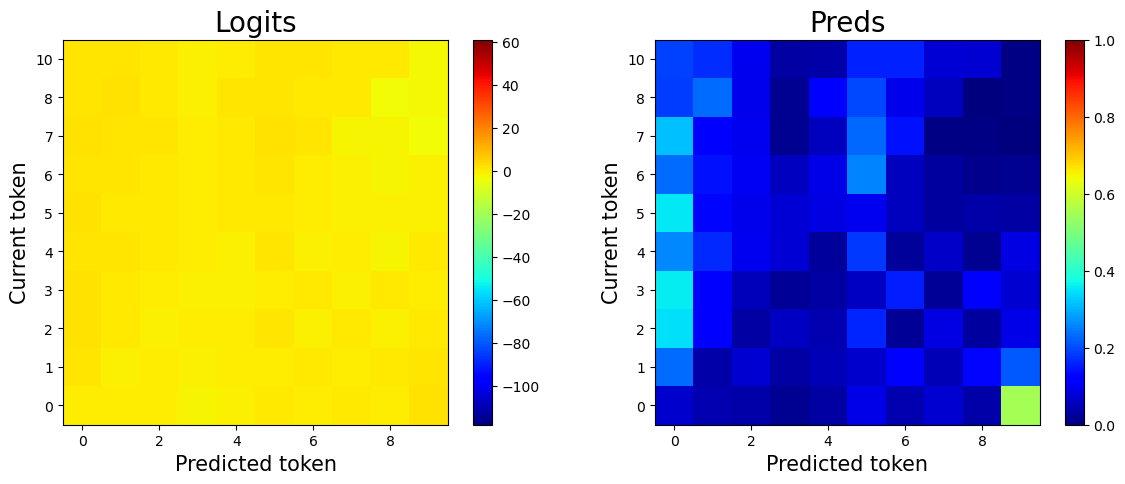

In [56]:
plot_predictions(seq_bwd, ablate_mlp(seq_bwd), vmin=-118, vmax=61)